# AWESim SOSS Pipeline

**Analyzing Webb Exoplanet Simulations with SOSS**

1. Select target (here: WASP-107b)
2. Generate planetary transmission spectrum (ExoTransmit)
3. Interpolate stellar models to generate unique spectrum for this target
4. Generate N (nTimes) stellar spectra with BATMAN model for stellar+planetary spectra
5. Generate SOSS images for each of the N spectra -- simulated transit observation
6. Extract 1D spectra from the 2D spectral images, as though they were 'real' observations
7. Divide the 1D spectra by the median out-of-transit stellar spectra (as template) to generate spectroscopic transit lightcurves
8. Fit BATMAN light curves (try KTRANSIT later) to each wavelength binned spectroscopic transit lightcurves
9. Use CHIMERA to retrieve planetary atmospheric abundances. **(CURRENT: BATMAN spectrum not aligned correctly)**
10. Compare to injected planetary spectrum (ExoTransmit)


In [1]:
# Magic functions
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import pickle
import batman
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as q
import astropy.constants as ac

from sklearn.externals import joblib

from ExoCTK import svo
from ExoCTK import core
from AWESim_SOSS.synSOSS import awesim

In [3]:
plt.rcParams['figure.dpi'] = 300

In [4]:
os.environ['MODELGRID_DIR'] = '/Users/jonathan/Research/synphot-data/ACES/default/'

In [5]:
# Create time axis for our simulations
bjd = np.linspace(-0.2, 0.2, 200)

In [6]:
K = svo.Filter('2MASS.Ks')

# WASP-107b TSO

Here is how to generate time series observations of a brown dwarf (or any other isolated star with no transiting planet).

We need two components to generate this simulation:
- A flux calibrated stellar spectrum
- A time axis for each frame of the TSO

We will pull a model spectrum for our desired object from the Phoenix ACES library and flux calibrate it so that it has a 9.3 K-band magnitude.

# Generate Stella Spectrum from Interpolated PHOENIX-ACES Models

In [7]:
# Stellar spectrum from model grid @ mu=1
teff, logg, feh = 4430, 4.51, 0.02
model_grid = core.ModelGrid(os.environ['MODELGRID_DIR'], Teff_rng=(4400,4500), logg_rng=(4.5,5), FeH_rng=(0,0.5), wave_rng=(0.5,2.8), resolution=700)
star = model_grid.get(teff, logg, feh)
wave_s_raw, flux_s_raw = star['wave'], star['flux'][-1]

518 models loaded from /user/jfilippazzo/Models/ACES/default/
8/518 spectra in parameter range Teff: (4400, 4500) , logg: (4.5, 5) , FeH: (0, 0.5) , wavelength: (0.5, 2.8)
Loading flux into table...
100.00 percent complete!
Interpolating grid point [4430/4.51/0.02]...
Run time in seconds:  10.012760877609253


## WASP-107 TSO (without planet)

Now let's scale it from the stellar surface (which is just the model grid output) to our desired K magnitude.

In [8]:
# Scale by K magnitude
Kmag = 8.637 # From SIMBAD
wave_s, flux_s, *_ = awesim.norm_to_mag([wave_s_raw*q.um,flux_s_raw*q.erg/q.s/q.cm**2/q.AA], Kmag, K)
WASP107 = [wave_s, flux_s]
joblib.dump(dict(waves=WASP107[0], flux=WASP107[1]), 'AWESim_SOSS/example_results/wasp107_injection_spectrum.save');

**Plot the High Resolution Stellar Spectrum**

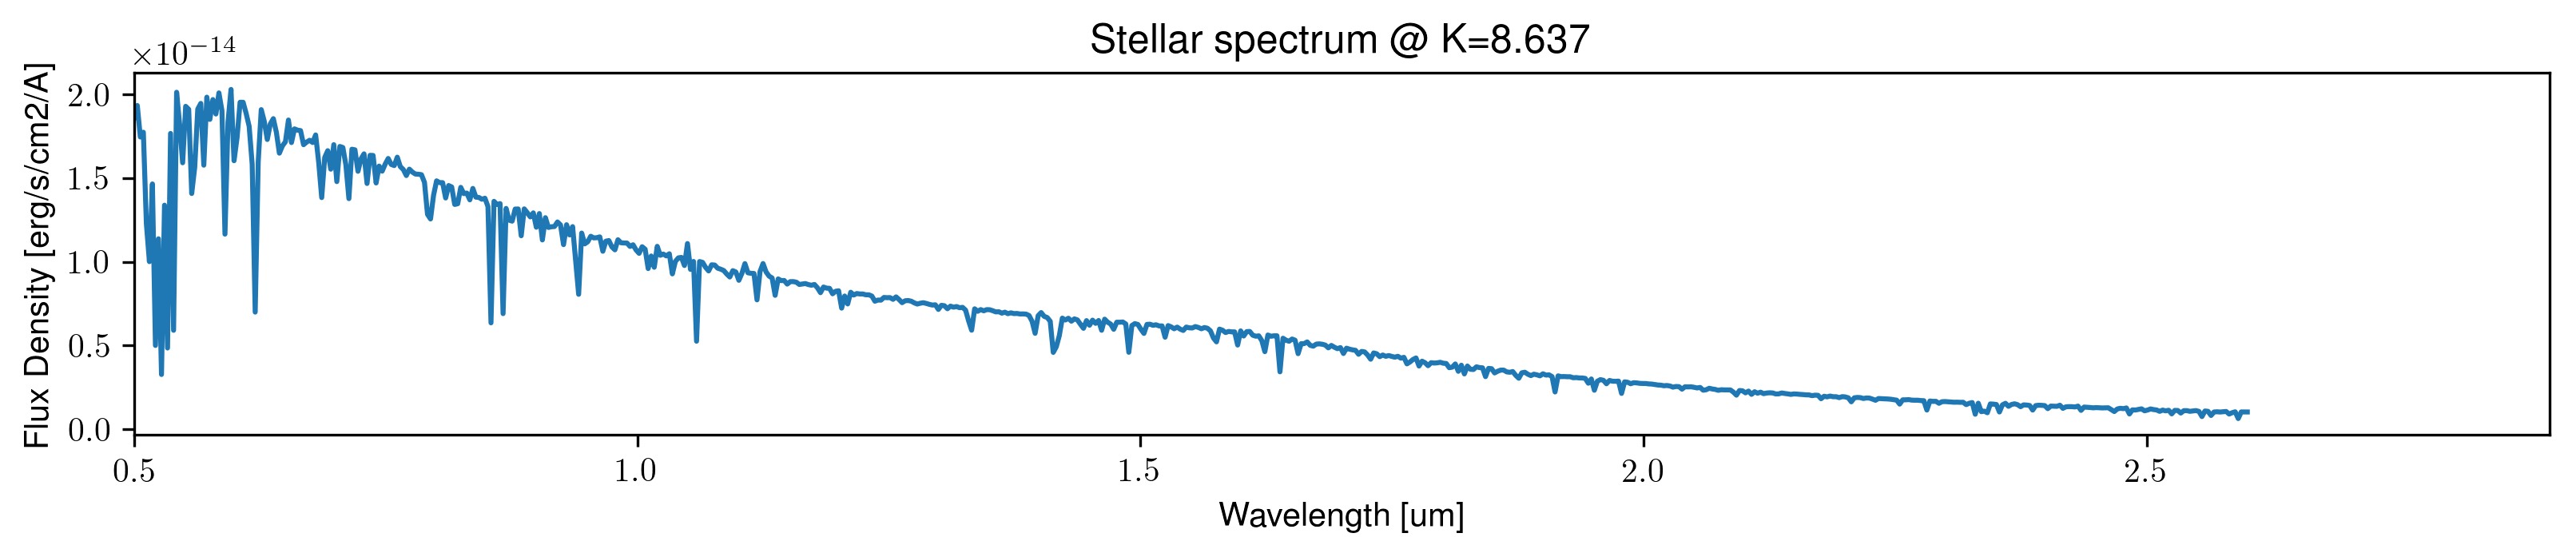

In [9]:
# Plot it 
plt.figure(figsize=(13,2));
plt.plot(*WASP107);
plt.xlim(0.5,2.9);
plt.title('Stellar spectrum @ K={}'.format(Kmag));
plt.ylabel('Flux Density [erg/s/cm2/A]');
plt.xlabel('Wavelength [um]');

## WASP 107 TSO (with planet)

We need five components to generate a transiting exoplanet:
- A flux calibrated stellar spectrum
- A time axis for each frame of the TSO
- A transmission spectrum of the planet
- A map of the limb darkening coefficients at each pixel
- The orbital parameters of the planet

We have the stellar spectrum from above so let's get the planetary transmission spectrum (generated with Exotransmit).

# Generate Planetary Spectrum from ExoTransmit

**Load from file**

In [10]:
# Get the forward model planet spectrum generated by Matt...
WASP107b = np.genfromtxt('AWESim_SOSS/wasp107_data/WASP107b_pandexo_input_spectrum.dat', unpack=True)

**Plot the High Resolution Planetary Spectrum**

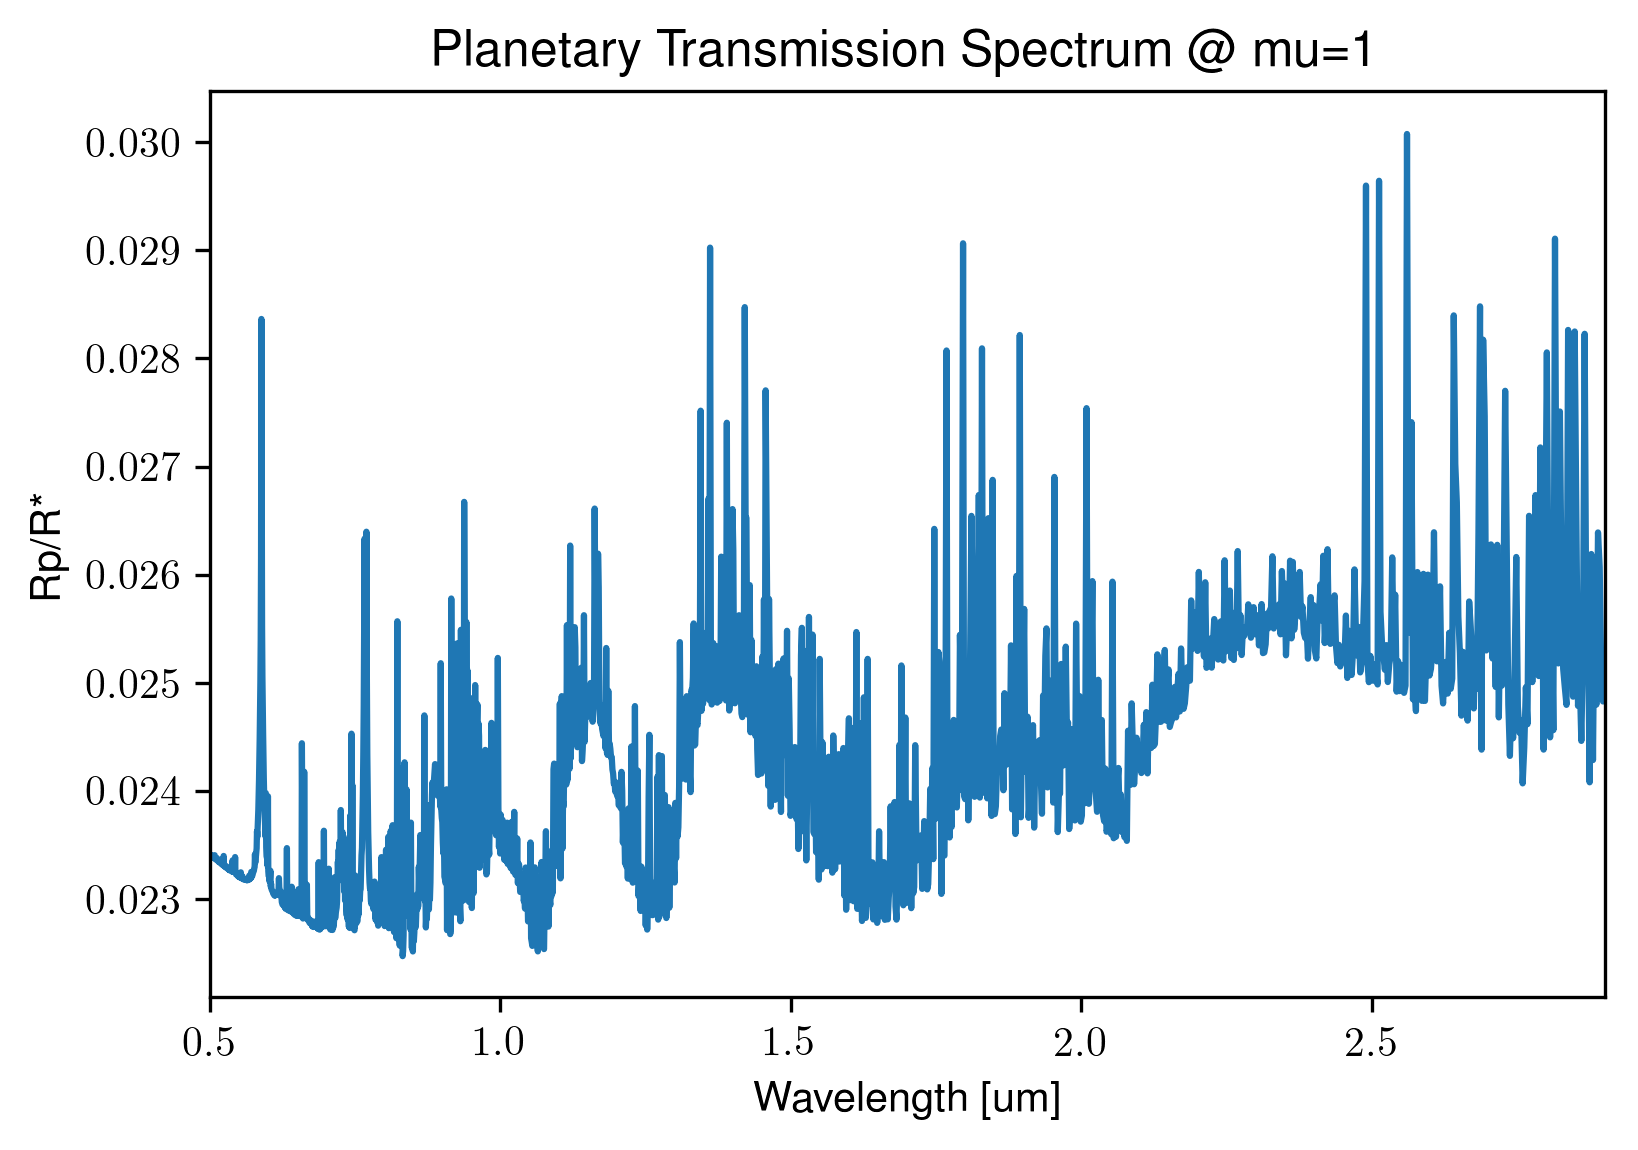

In [11]:
# Plot it
plt.plot(*WASP107b);
plt.xlim(0.5,2.9);
plt.title('Planetary Transmission Spectrum @ mu=1');
plt.ylabel('Rp/R*');
plt.xlabel('Wavelength [um]');

Now we must calaulate a map of the limb darkening coefficients for the star through the GR700XD filter. This takes a few minutes so I precomputed and saved the values.

# Compute Limb Darkening Profile for Stellar Disk

**Load from file**

In [12]:
# Specify the limb darkening profile
profile = 'quadratic'

# # ================================================================================================================================================
# # Get the GR700XD filter throughput
# filt = os.path.join(os.path.join(os.path.dirname(core.__file__),'AWESim_SOSS/data/filters/NIRISS.GR700XD.1.txt'))
# GR700XD = svo.Filter('GR700XD', np.genfromtxt(filt, unpack=True), n_bins=85, wl_min=0.8*q.um, wl_max=2.5*q.um)
# GR700XD.plot()
# GR700XD.info()

# Calculate the limb darkening coefficients for 85 bins between 0.8 and 2.5um
# savepath = '/Users/jfilippazzo/Desktop/WASP107_LDC.txt'
# ldcs = lf.ldc(teff, logg, feh, model_grid, ['quadratic'], bandpass=GR700XD, grid_point=star.copy(), mu_min=0.08, save=savepath)

# GR700XD_WL = svo.Filter('GR700XD', np.genfromtxt(filt, unpack=True), n_bins=1, wl_min=0.8*q.um, wl_max=2.5*q.um)
# ldcs_WL = lf.ldc(teff, logg, feh, model_grid, ['quadratic'], bandpass=GR700XD_WL, grid_point=star.copy(), mu_min=0.08, save=savepath.replace('.txt','_WL.txt'), plot=True)

# w0, c1, e1, c2, e2 = list(zip(*ldcs['quadratic']['coeffs']))
# plt.scatter(c1, c2, c=w0, cmap='viridis')
# plt.colorbar()
# w0, c1, e1, c2, e2 = list(zip(*ldcs_WL['quadratic']['coeffs']))
# plt.scatter(c1[0], c2[0], c='r', s=50, zorder=10)
# plt.xlabel('c1')
# plt.ylabel('c2')

# Generate the coefficient wave map
# ld_coeffs_lookup = spec2D.ld_coefficient_lookup(lam1, profile, star, model_grid)
# coeff_map = spec2D.ld_coefficients(lam1, ld_coeffs_lookup)
# np.save('AWESim_SOSS/{}_ldc_map.npy'.format(profile), coeff_map)
# # ================================================================================================================================================

# Get the LDC map from file
ld_coeffs = joblib.load('AWESim_SOSS/wasp107_data/{}_ldc_map.save'.format(profile))

Now let's use Batman to set the orbital paramaters.

**Establish the Transit Parameters**

In [13]:
# Set the wavelength independent orbital parameters
params = batman.TransitParams()
params.t0 = 0.                                # time of inferior conjunction
params.per = 5.7214742                        # orbital period
params.a = 0.0558*q.AU.to(ac.R_sun)*0.66      # semi-major axis (in units of stellar radii)
params.inc = 89.8                             # orbital inclination (in degrees)
params.ecc = 0.                               # eccentricity
params.w = 90.                                # longitude of periastron (in degrees)

# Test it
params.limb_dark = 'quadratic'
params.u = ld_coeffs[5]
params.rp = (0.94*ac.R_jup.to(ac.R_sun)*0.66).value

**Plot and Example Transit Light Curve**

Establishes that the timing array is valid

(0.995, 1.0005)

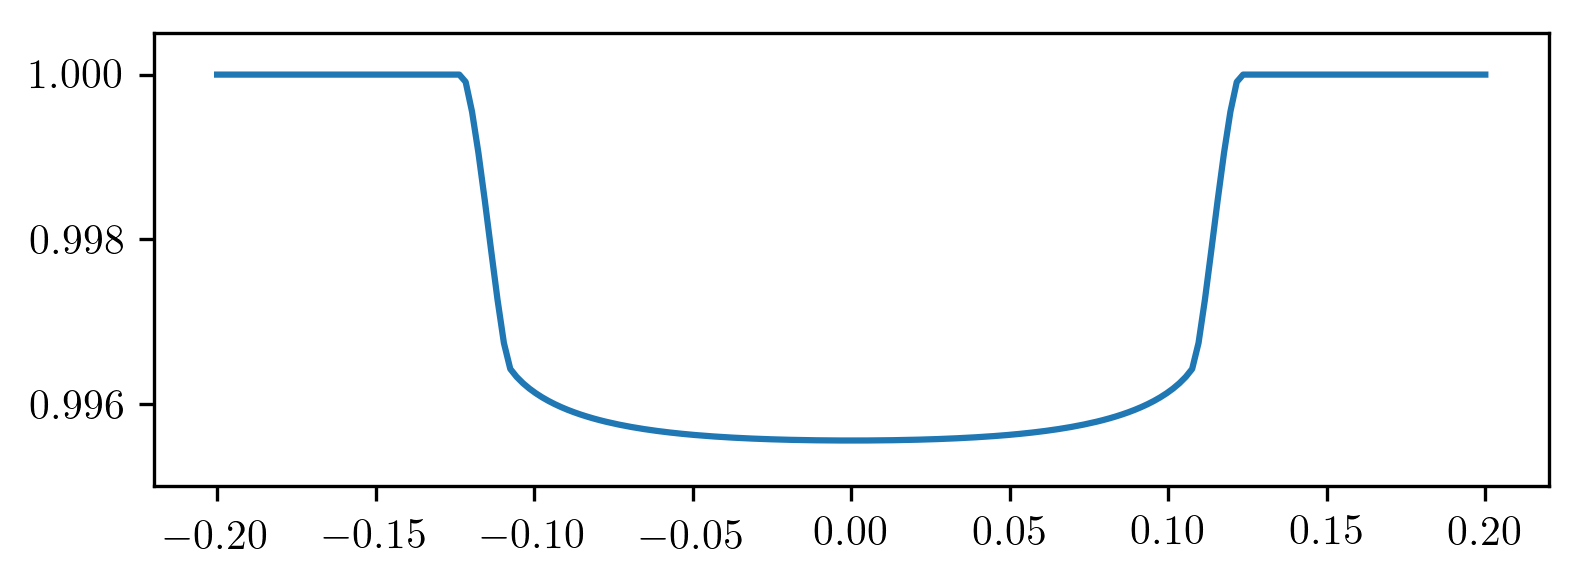

In [14]:
# Generate the light curve for this pixel
m = batman.TransitModel(params, bjd) 
lc = m.light_curve(params)

plt.figure(figsize=(6,2))
plt.plot(bjd, lc)
plt.ylim(0.995,1.0005)

# Generate SOSS Spectroscopic Images over Time with Planetary Spectrum

Now we can run the simulator.

In [15]:
# Create TSO object
TSO4 = awesim.TSO(bjd, WASP107, WASP107b, params, ld_coeffs)

In [16]:
TSO4.compute_light_curve_order(orders=[1,2])

Calculating order 1 light curves...
Order 1 light curves finished:  23.782904863357544
Calculating order 2 light curves...
Order 2 light curves finished:  24.39857316017151
Why are you subtracting Gaussian noise -- centered at 1 --                     instead of adding it -- centered at 0?


**Plot Example SOSS Spectroscopic Image of the Host Star**

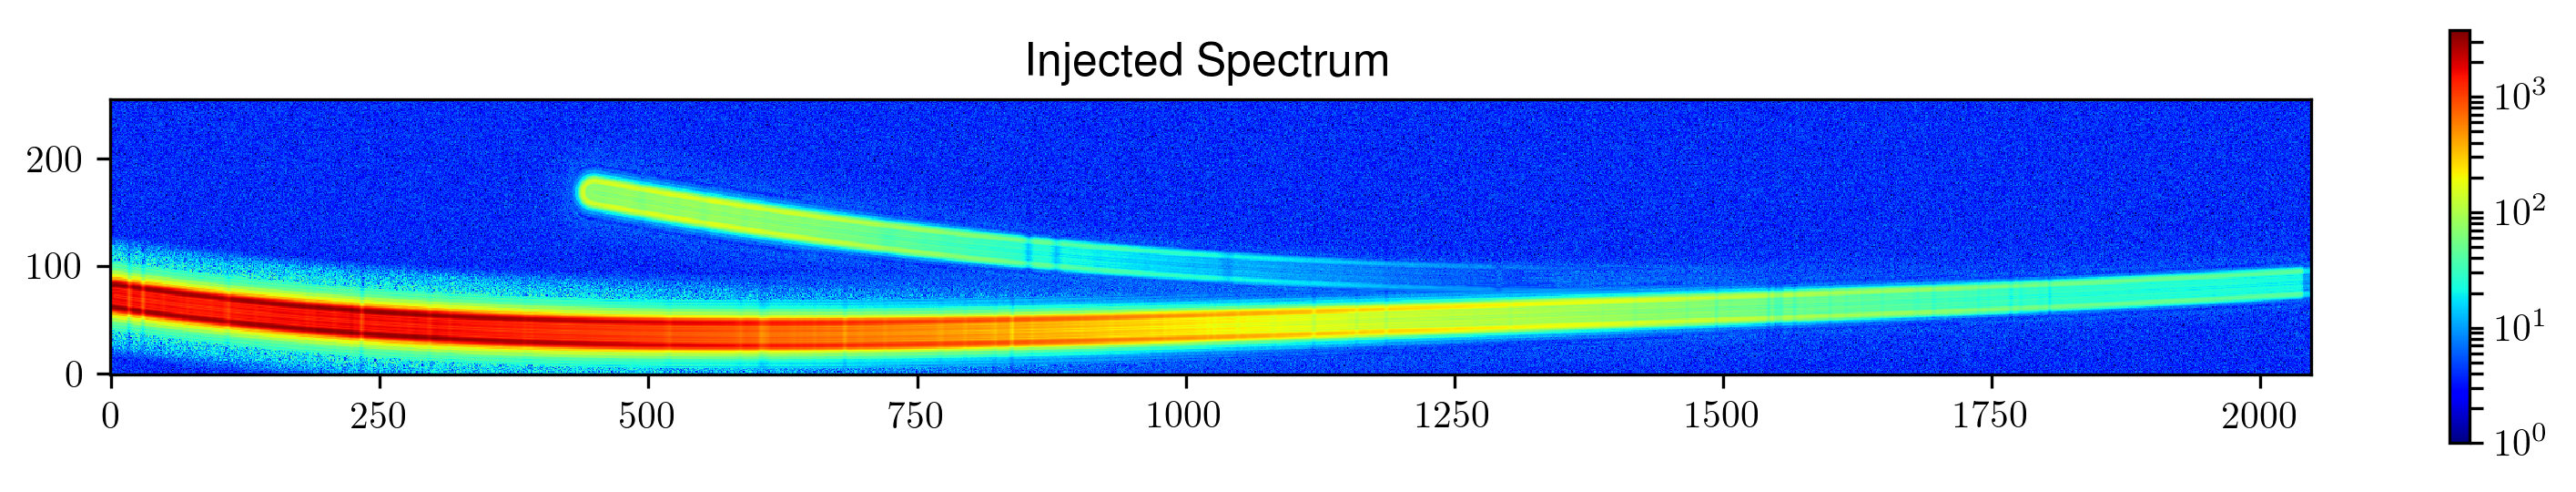

In [17]:
TSO4.plot_frame()

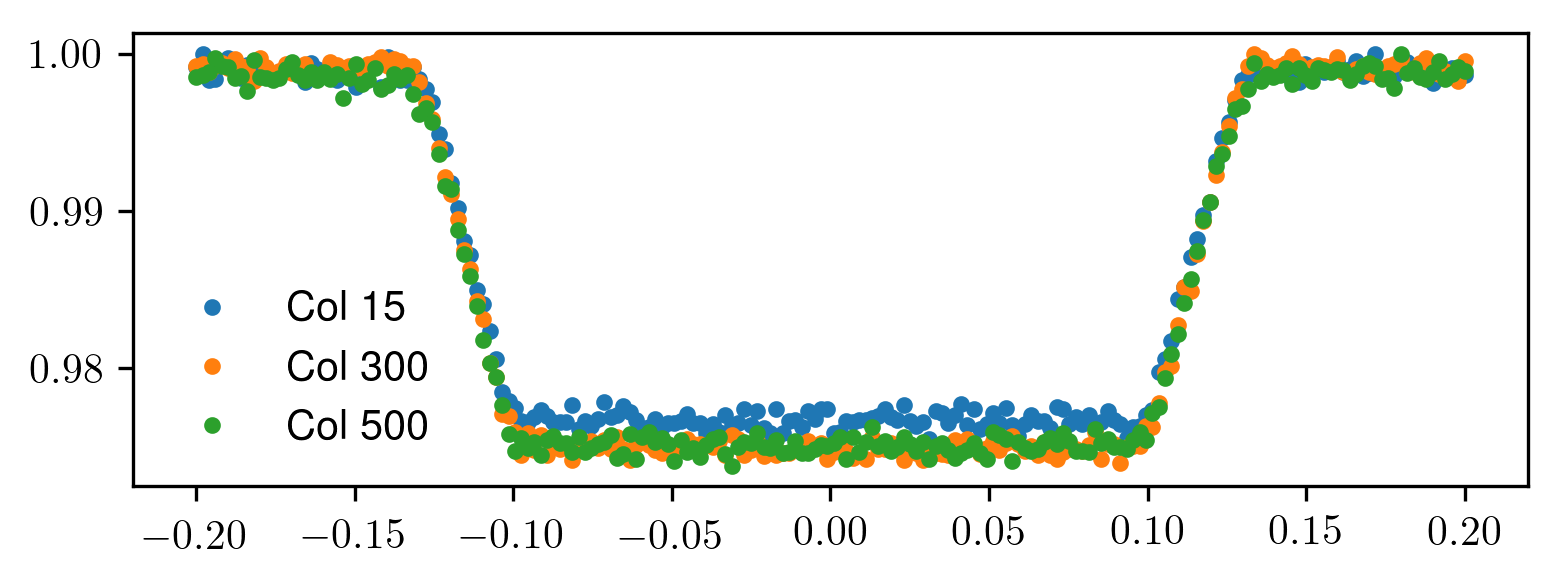

In [18]:
plt.figure(figsize=(6,2))
TSO4.plot_lightcurve([15,300,500])

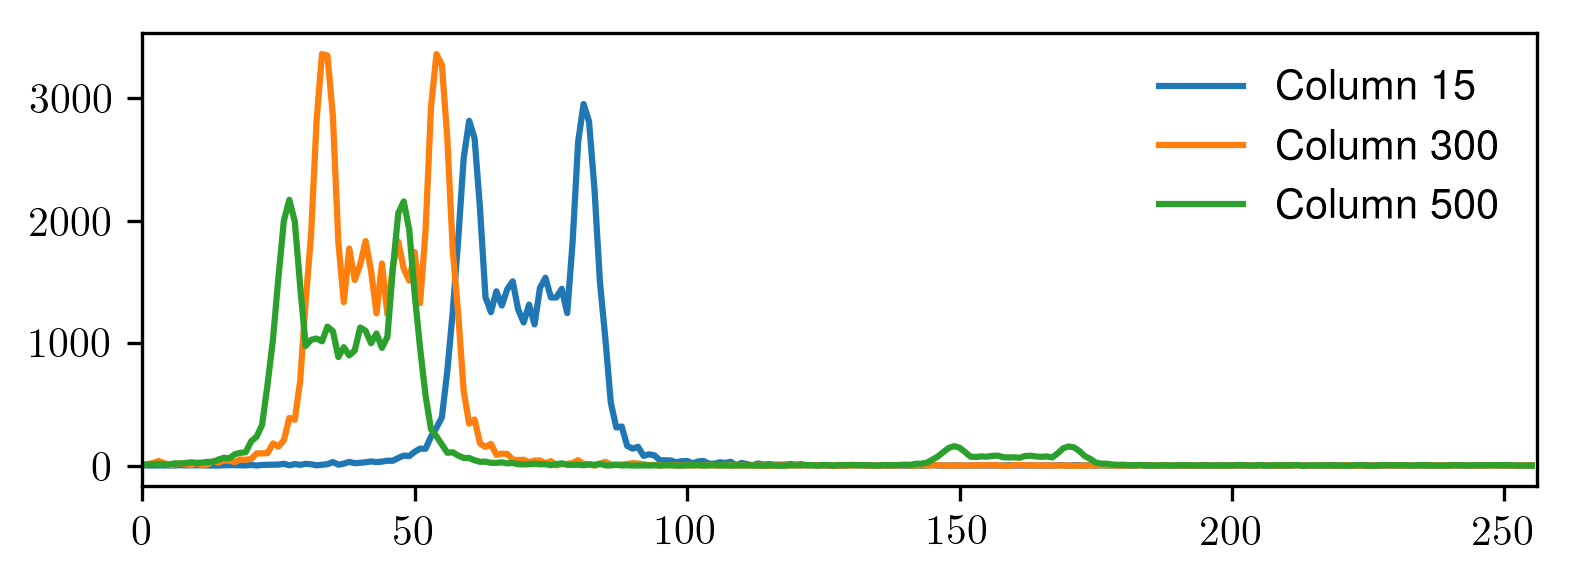

In [19]:
plt.figure(figsize=(6,2))
TSO4.plot_slice([15,300,500])

In [20]:
TSO4.save_tso('AWESim_SOSS/example_results/wasp107b_stellar_spectra_with_transit_over_time.save') # saves to file "dummy.save"

Saving TSO class dict to AWESim_SOSS/example_results/wasp107b_stellar_spectra_with_transit_over_time.save


# Extract 1D spectra from Simulated 2D SOSS Spectroscopic Images

In [21]:
from astropy.io import fits
from matplotlib.colors import LogNorm
import warnings
import glob
from AWESim_SOSS.extract1D import get1Dspectrum as getSpec1D

from sklearn.externals import joblib

warnings.simplefilter("ignore")

**Load SOSS Spectroscopic Images**

In [22]:
aweSimSoss  = joblib.load('AWESim_SOSS/example_results/wasp107b_stellar_spectra_with_transit_over_time.save')

In [23]:
data2D  = aweSimSoss['tso']

Check the Data Dimsensions: nTimes x nRows x nWaves 

In [24]:
# Let's grab the 2D data using a workaround for Github's 100MB file size limit!
# Normally, we would just do `data2D = fits.getdata(filename)'
nTimes, nRows, nWaves = data2D.shape
print('nTimes:\t{}\nnRows:\t{}\nnWaves:\t{}'.format(nTimes, nRows, nWaves))

nTimes:	200
nRows:	256
nWaves:	2048


Notice the shape of the data is `(200, 256, 2048)` since the reduced data are comprised of 200 slope images of the SOSS SUBSTRIP256 subarray, which is 256 rows and 2048 columns. Let's take a glance at one of the integrations.

**Plot Example SOSS Spectroscopic Image**

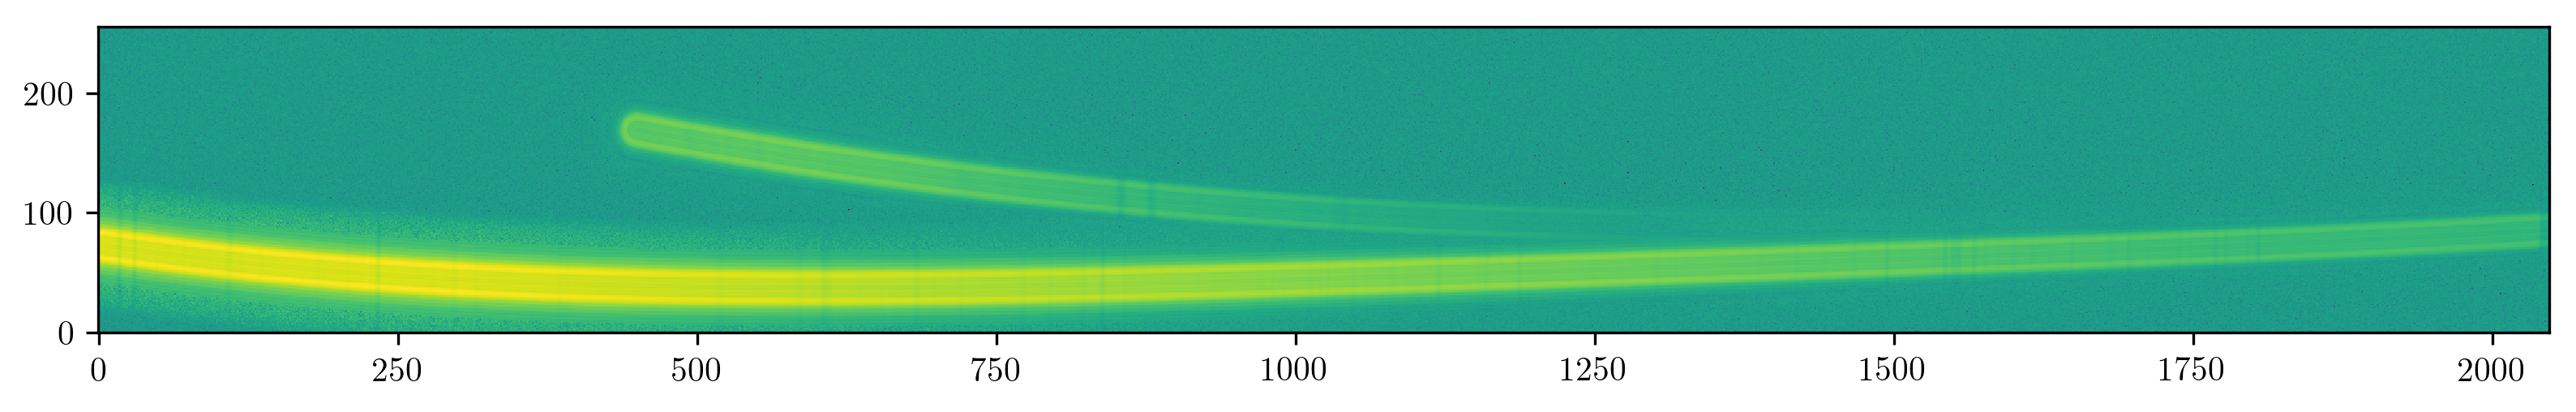

In [25]:
plt.figure(figsize=(13,2));
plt.imshow(data2D[0], interpolation='none', norm=LogNorm(), origin='lower');

The image above should clearly show the three orders of the NIRISS SOSS spectra (1st, 2nd, and 3rd from bottom to top). The 1st order covers roughly 0.7-2.8 microns, the 2nd order covers roughly 0.6-1.3 microns, and the 3rd order covers roughly 0.6-0.85 microns. Wavelength increases to the right in the image above, with the 1st and 2nd order overlapping at the long wavelength end.

Results from the ISIM Cryo-vacuum Test 3 suggest that the actual data that come off the telescope will look slightly different, with somewhat more of a counter-clockwise rotation and somewhat more overlap of the 1st and 2nd order traces past pixel column 1300. The 3rd order trace will likely be unusable in all but the highest signal-to-noise observations.

## Quickly extract the 1D spectra from the 2D trace data

What we would like from these data are an array of 333 1-D spectra for each spectral order along with their associated Julian Days. Then we can fit lightcurves to the spectra to find our planet.

In the interests of time, we will extract only the 1st order spectra. The routine below assigns an average wavelength to each of the 2048 columns of the SOSS subarray, applies a mask to isolate the 1st order trace from background and higher order pixels, and then performs a simple column sum. 

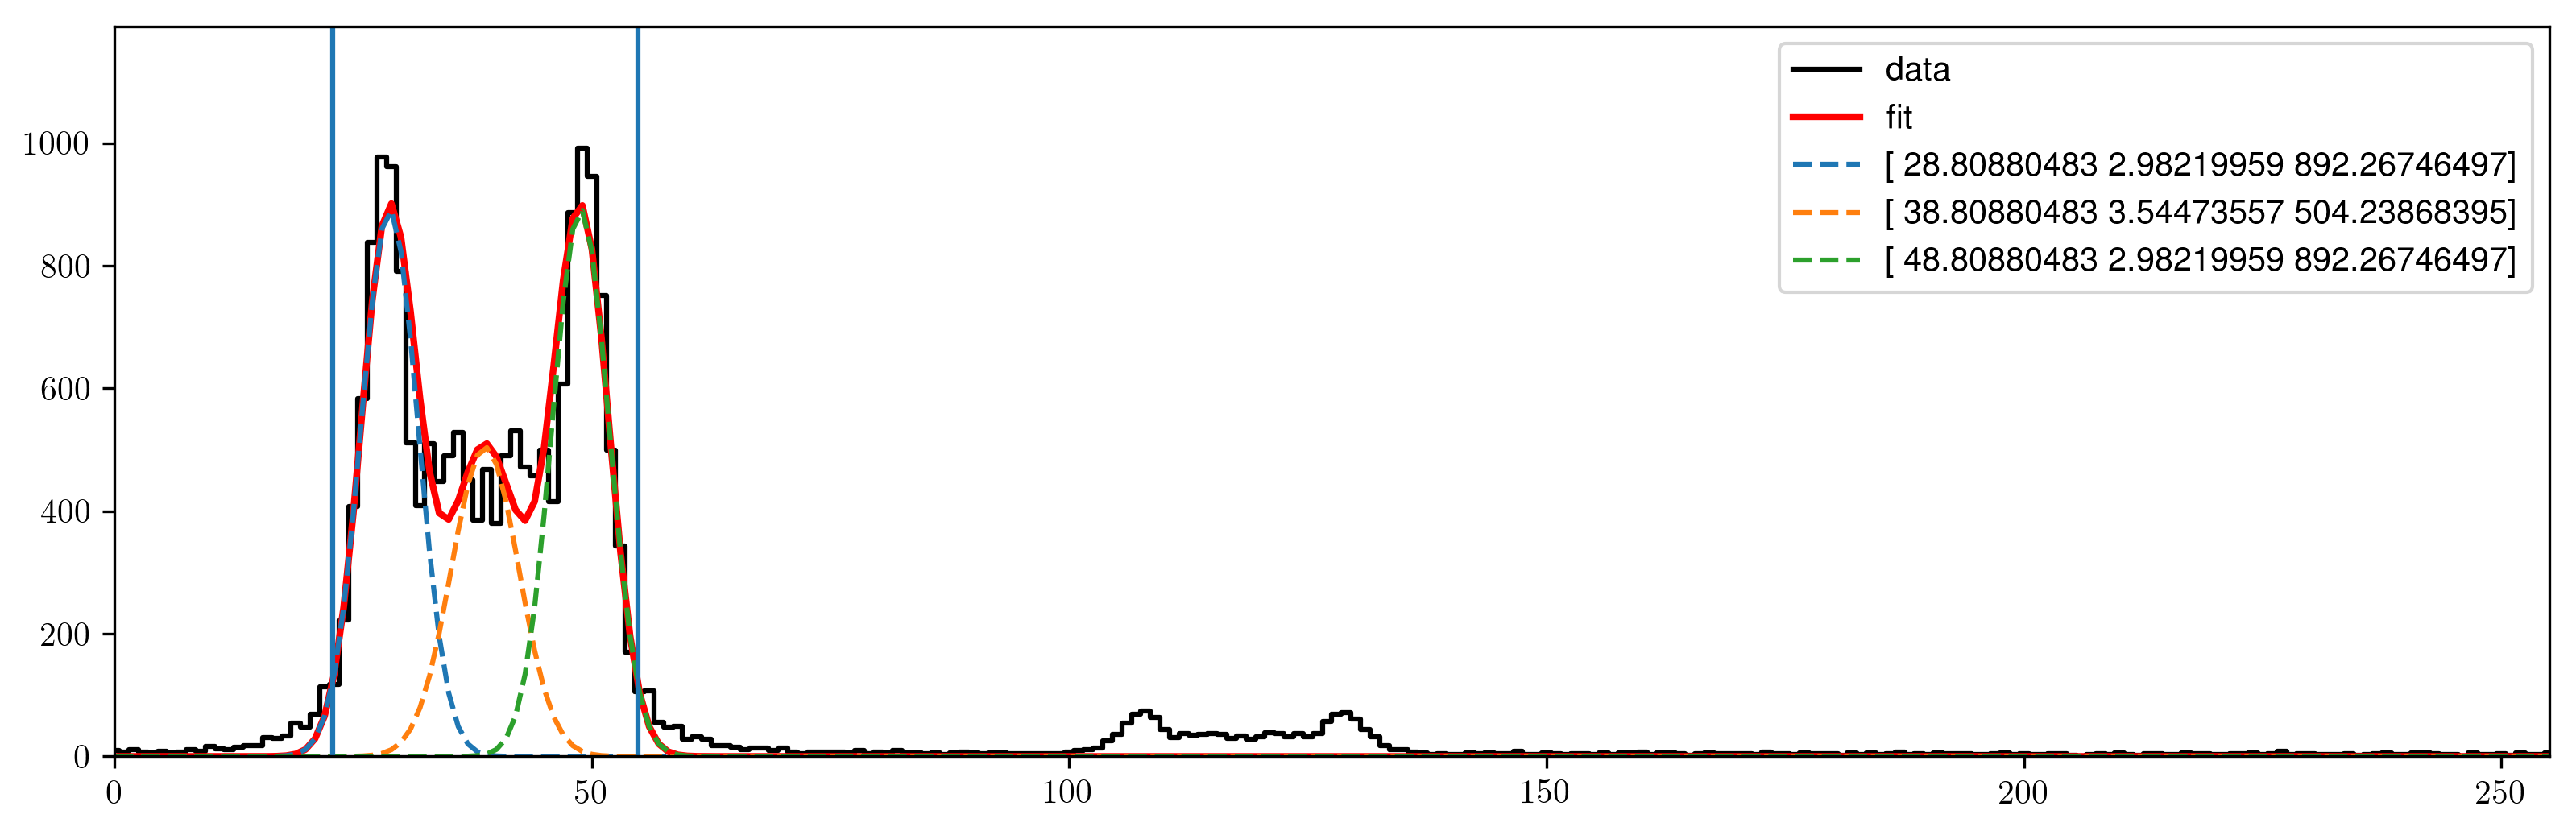

In [26]:
# Look at the cross section
bat_bounds = ([1,2,100,3,50,1],[120,5,1500,10,1500,20])
psf = getSpec1D.isolate_signal(data2D[23][:,800], func=getSpec1D.batman, bounds=bat_bounds, plot=True)

**Generate Median Spectrum**

In [27]:
med_data2D = np.nanmedian(data2D, axis=0)

**Isolate the 1st order trace by fitting a function to each column (~5 minutes)**

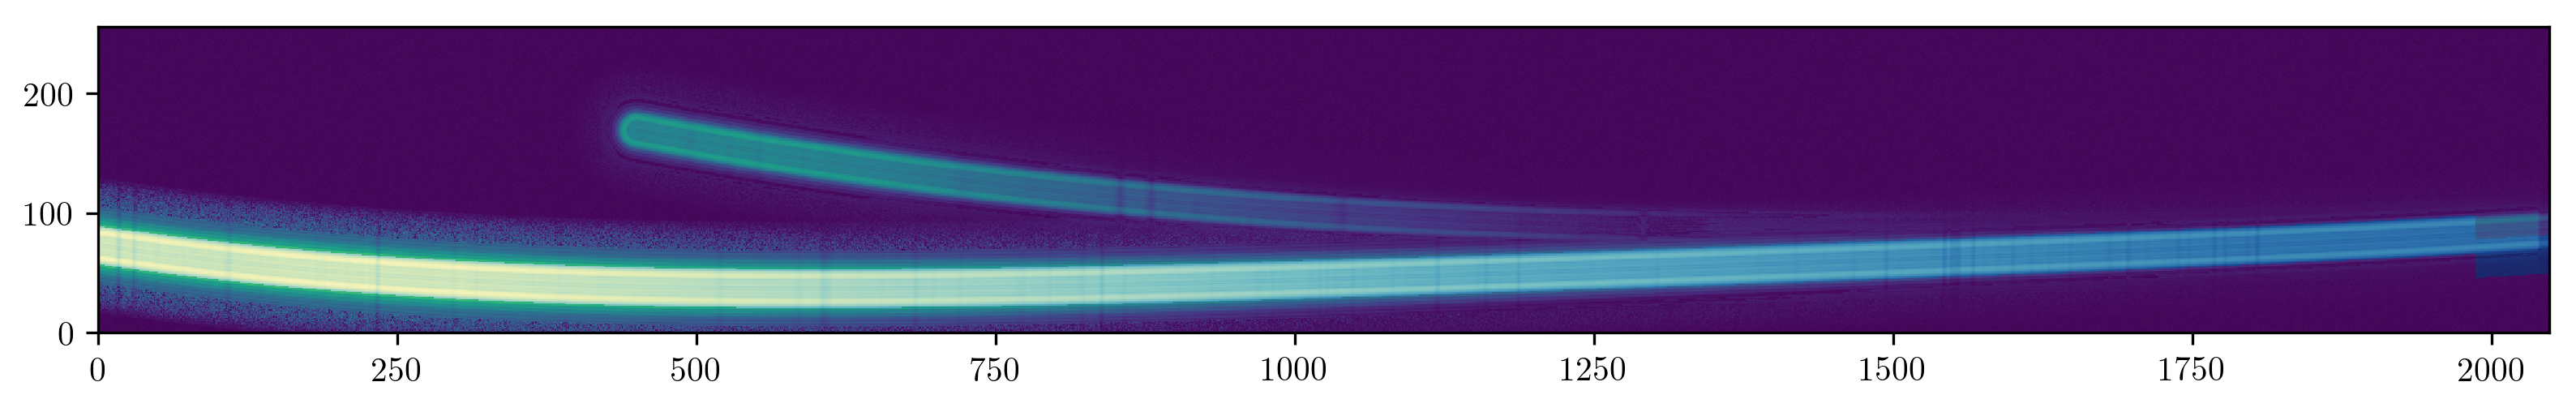

In [28]:
mask = getSpec1D.function_trace(med_data2D.T, func=getSpec1D.batman, bounds=bat_bounds, smooth='', start=(200,100), plot=True).mask

If we look at column 700, we can see the PSF for the 1st and 2nd order traces are a bounded triple gaussian, which looks like Batman. To create an aperture mask, we can just take the median frame and fit a Batman function column-by-column to isolate the trace pixels.

** Make it the correct shape**

In [29]:
full_mask = np.dstack([mask]*len(data2D)).T.swapaxes(1,2)

**Mask the 2D data**

In [30]:
masked_data2D = np.ma.array(data2D.copy(), mask=full_mask)

**Plot the Mask**

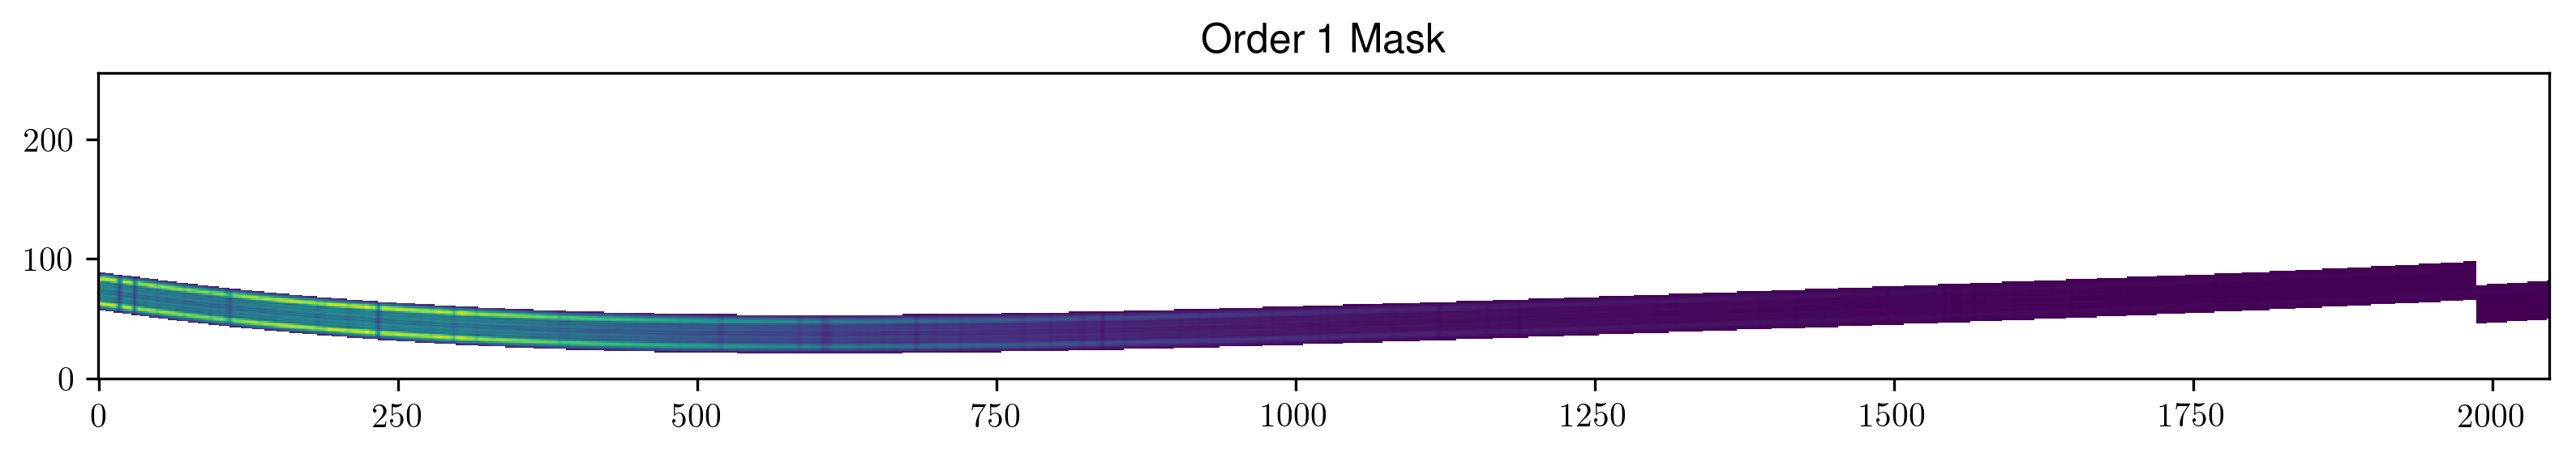

In [31]:
plt.figure(figsize=(13,2));
plt.imshow(masked_data2D[0], origin='lower');
plt.title('Order 1 Mask');

**Load Injected Stellar Spectrum**

In [32]:
wasp107_star = joblib.load(os.environ['HOME'] + '/Research/github/AWESim_SOSS/AWESim_SOSS/example_results/wasp107_injection_spectrum.save')

**Sum the counts in each column**

In [33]:
counts = np.nansum(masked_data2D, axis=1).data

**Generate a wavelength for each column**

In [34]:
wavelength = np.polyval([1.66371e-14,-4.19166e-11,3.09333e-08,-0.000984839,2.60188], np.arange(2048))[::-1]

(1, 1.25)

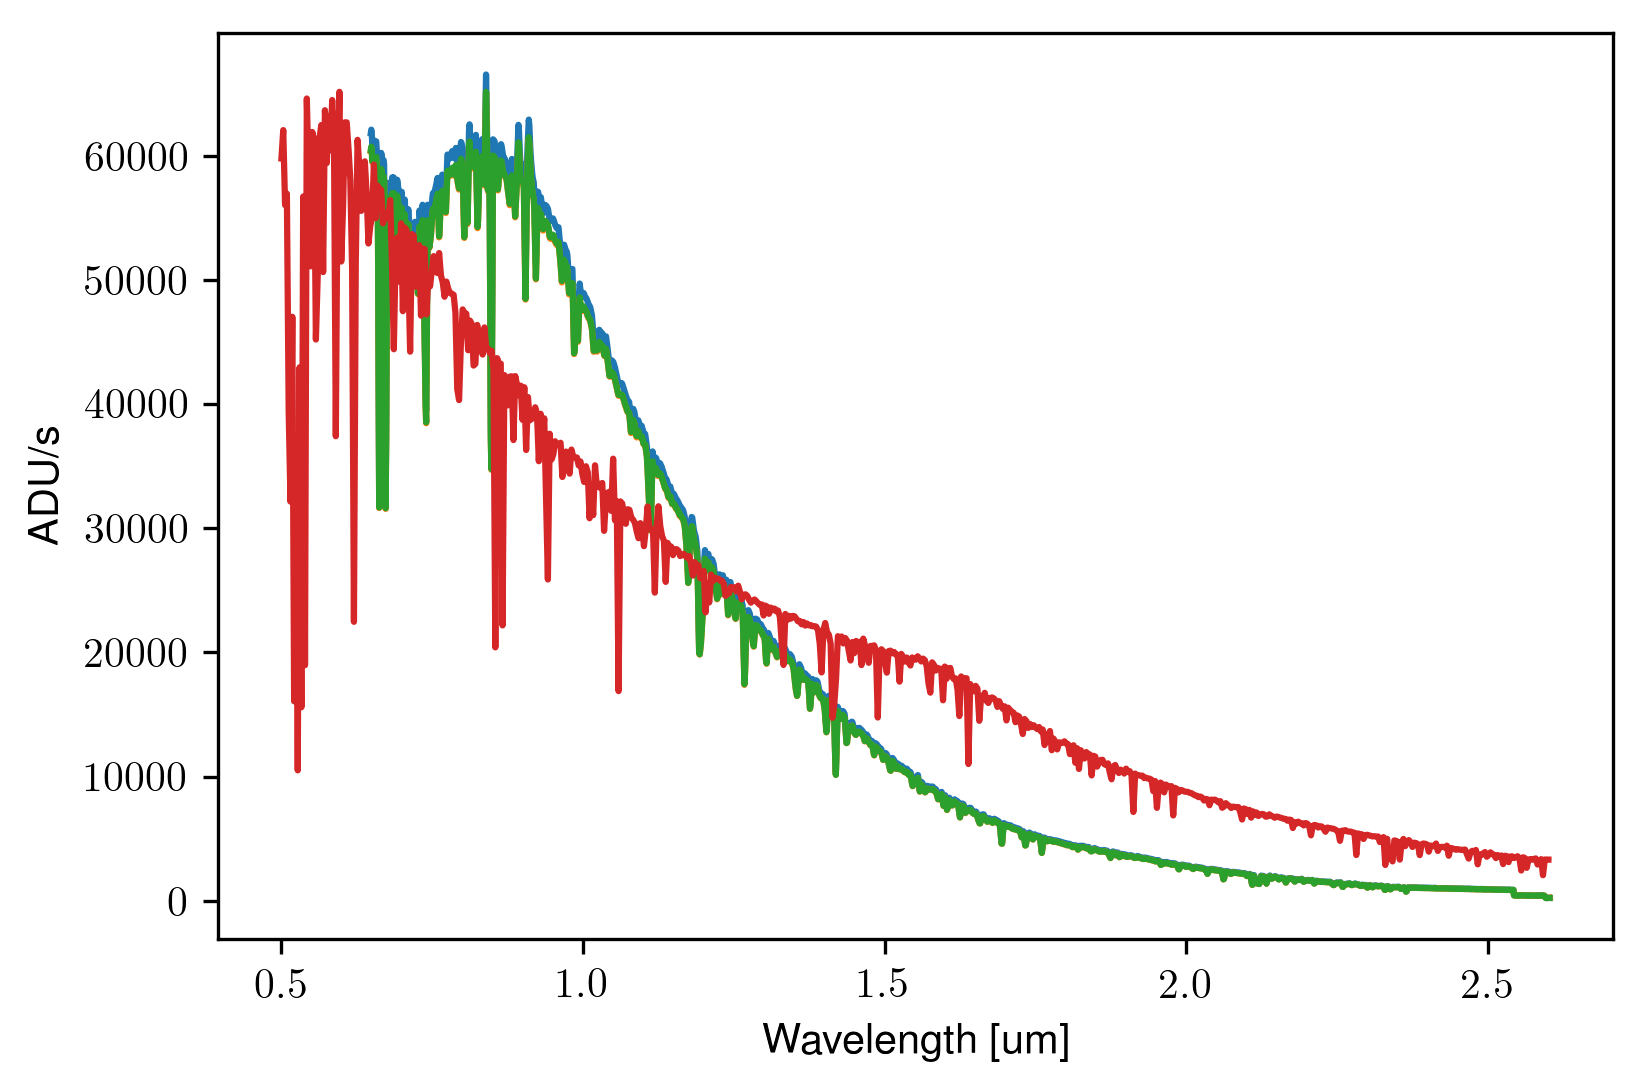

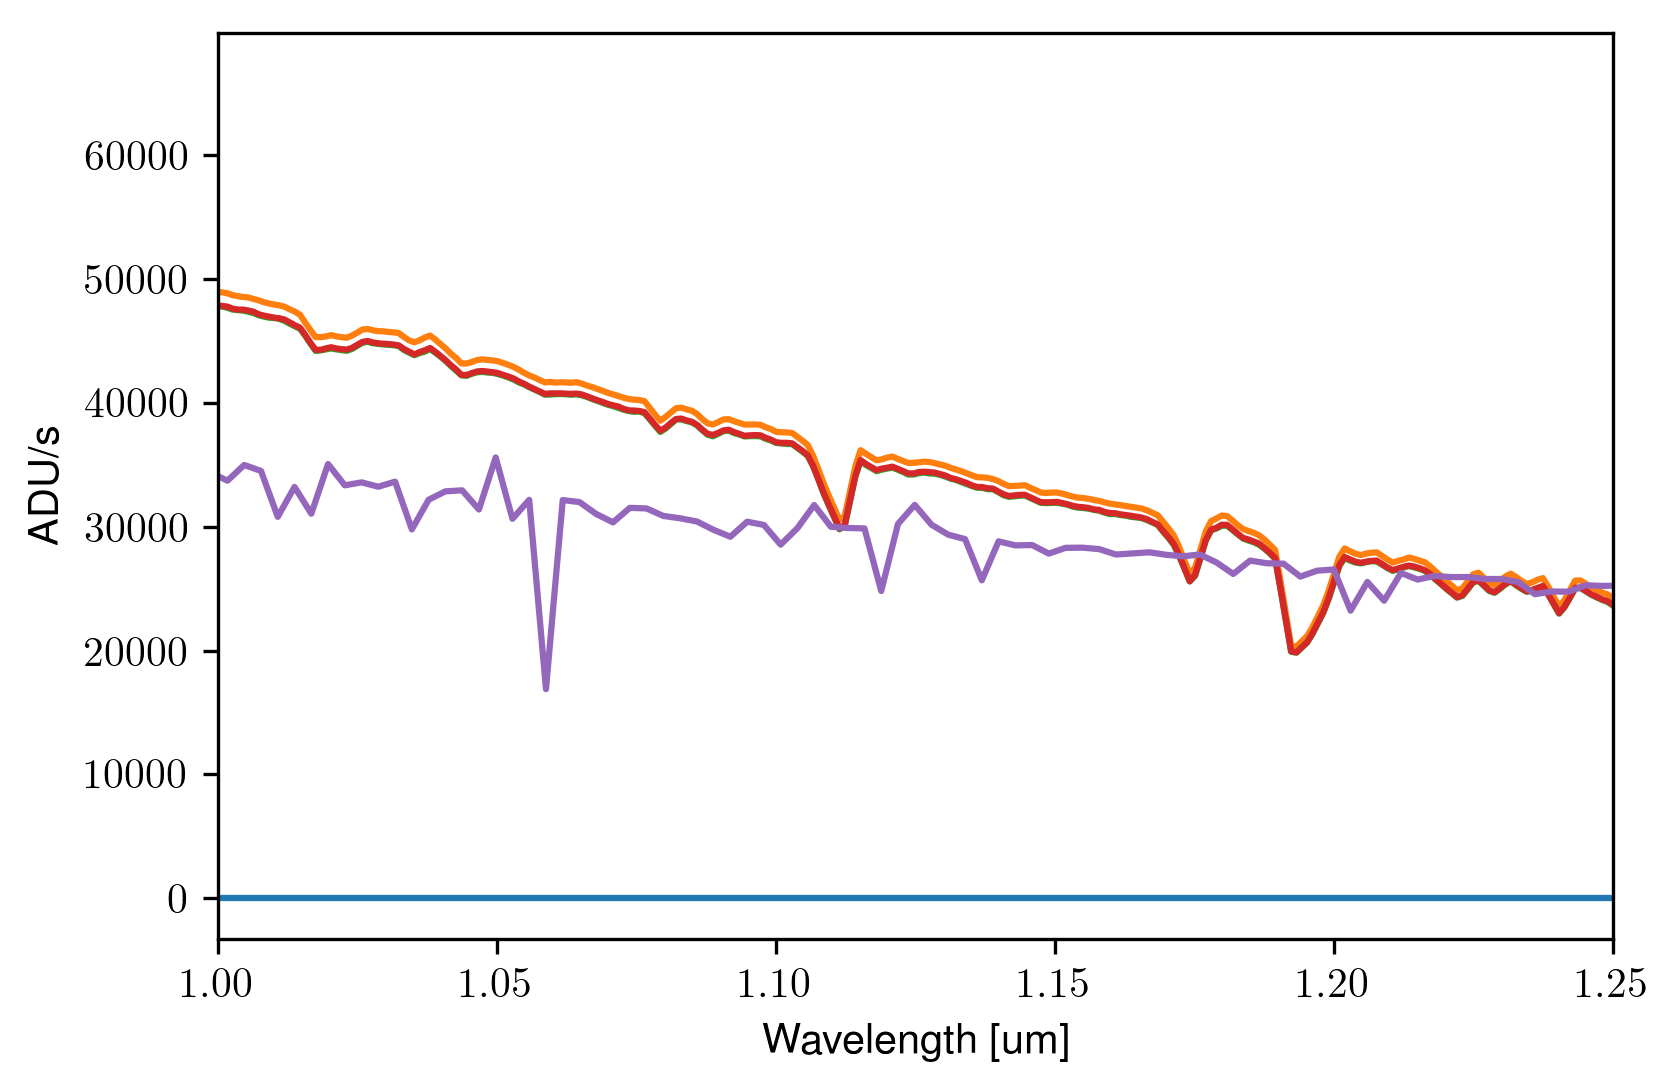

In [35]:
# Take a look!
plt.figure()
for c in counts[::75]:
    plt.plot(wavelength, c)

scale = c.max() / wasp107_star['flux'].value.max()
plt.plot(wasp107_star['waves'], wasp107_star['flux']*scale)
plt.xlabel('Wavelength [um]')
plt.ylabel('ADU/s')

# Zoom in
plt.figure()
plt.plot(wasp107_star['waves'], wasp107_star['flux'])
for c in counts[::75]:
    plt.plot(wavelength, c)

scale = c.max() / wasp107_star['flux'].value.max()
plt.plot(wasp107_star['waves'], wasp107_star['flux']*scale)
plt.xlabel('Wavelength [um]')
plt.ylabel('ADU/s')
plt.xlim(1,1.25)
# plt.ylim(26000,30000)

**Save Stellar Spectra over Tiem**

In [36]:
if not os.path.exists('data/'):
    os.mkdir('./data/')

In [37]:
joblib.dump(dict(wavelength=wavelength, counts=counts), 'AWESim_SOSS/example_results/wasp107_extracted_1D_spectra.save');

**Compare with a 'Known' Solution**

## Optimally extract the 1D spectra from the 2D trace data

We could also optimally extract the time-series 1D data, but that clocks in at a significantly longer runtime of about 30 minutes so we will not cover it in this workshop. The optimal extraction routine performs a true background subtraction, takes into account the trace curvature, corrects for order 1 and 2 overlap, and provides uncertainties.

Here's a look at some Cryo-vacuum Test 3 data which shows the more realistic trace shape with 1st and 2nd orders extracted.

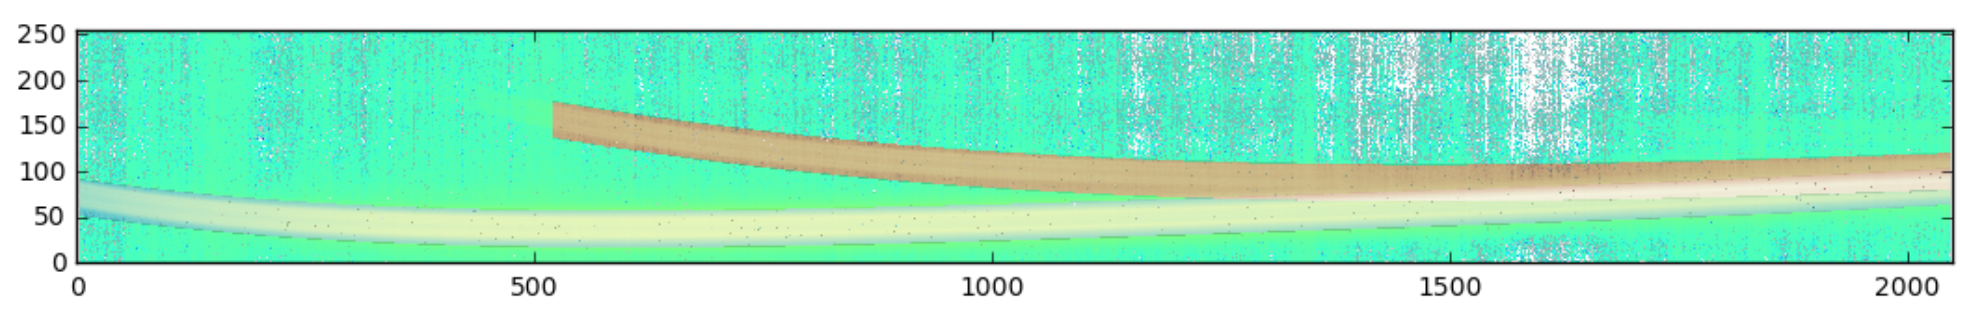

In [38]:
from IPython.display import Image
Image("AWESim_SOSS/extract1D/cv3_data.png")

# Fit Transit Light Curves to Each Spectral Bin

In [39]:
import batman
import lmfit

In [40]:
from AWESim_SOSS.lcfitting import transit_light_curve_fits as tlc_fits

**Define a wrapper function to assist with our fitting and allow us to interface with BATMAN and LMFIT.**

In [41]:
batman_wrapper_lmfit = tlc_fits.batman_wrapper_lmfit

**Set initial parameters using an ordered dictionary of Parameter objects**

In [42]:
planetParams = {'rprs':      (0.147   , True, 0.0, 0.2),
                'period':    (5.721490, False         ),
                'tcenter':   (0., True, -0.1, 0.1     ),
                'inc':       (89.7    , True, 80., 90.),
                'aprs':      (18.2    , True, 15., 20.),
                'ecc':       (0.0     , False         ),
                'omega':     (90.     , False         ),
                'u1':        (0.284   , True, 0., 1.  ),
                'u2':        (0.208   , True, 0., 1.  ),
                'offset':    (1.0     , True, 0.0     ),
                'slope':     (0.0     , False         ),
                'curvature': (0.0     , False         )
               }

initialParams = tlc_fits.default_init_params(planetName='WASP-107b', planetParams=planetParams)

**Load 1D Stellar Spectra over Time**

In [43]:
ls AWESim_SOSS/wasp107_data/wasp107_data

ls: AWESim_SOSS/wasp107_data/wasp107_data: No such file or directory


In [44]:
wasp107spec = joblib.load('AWESim_SOSS/example_results/wasp107_extracted_1D_spectra.save')

**Plot 1D Stellar Spectra through Time**

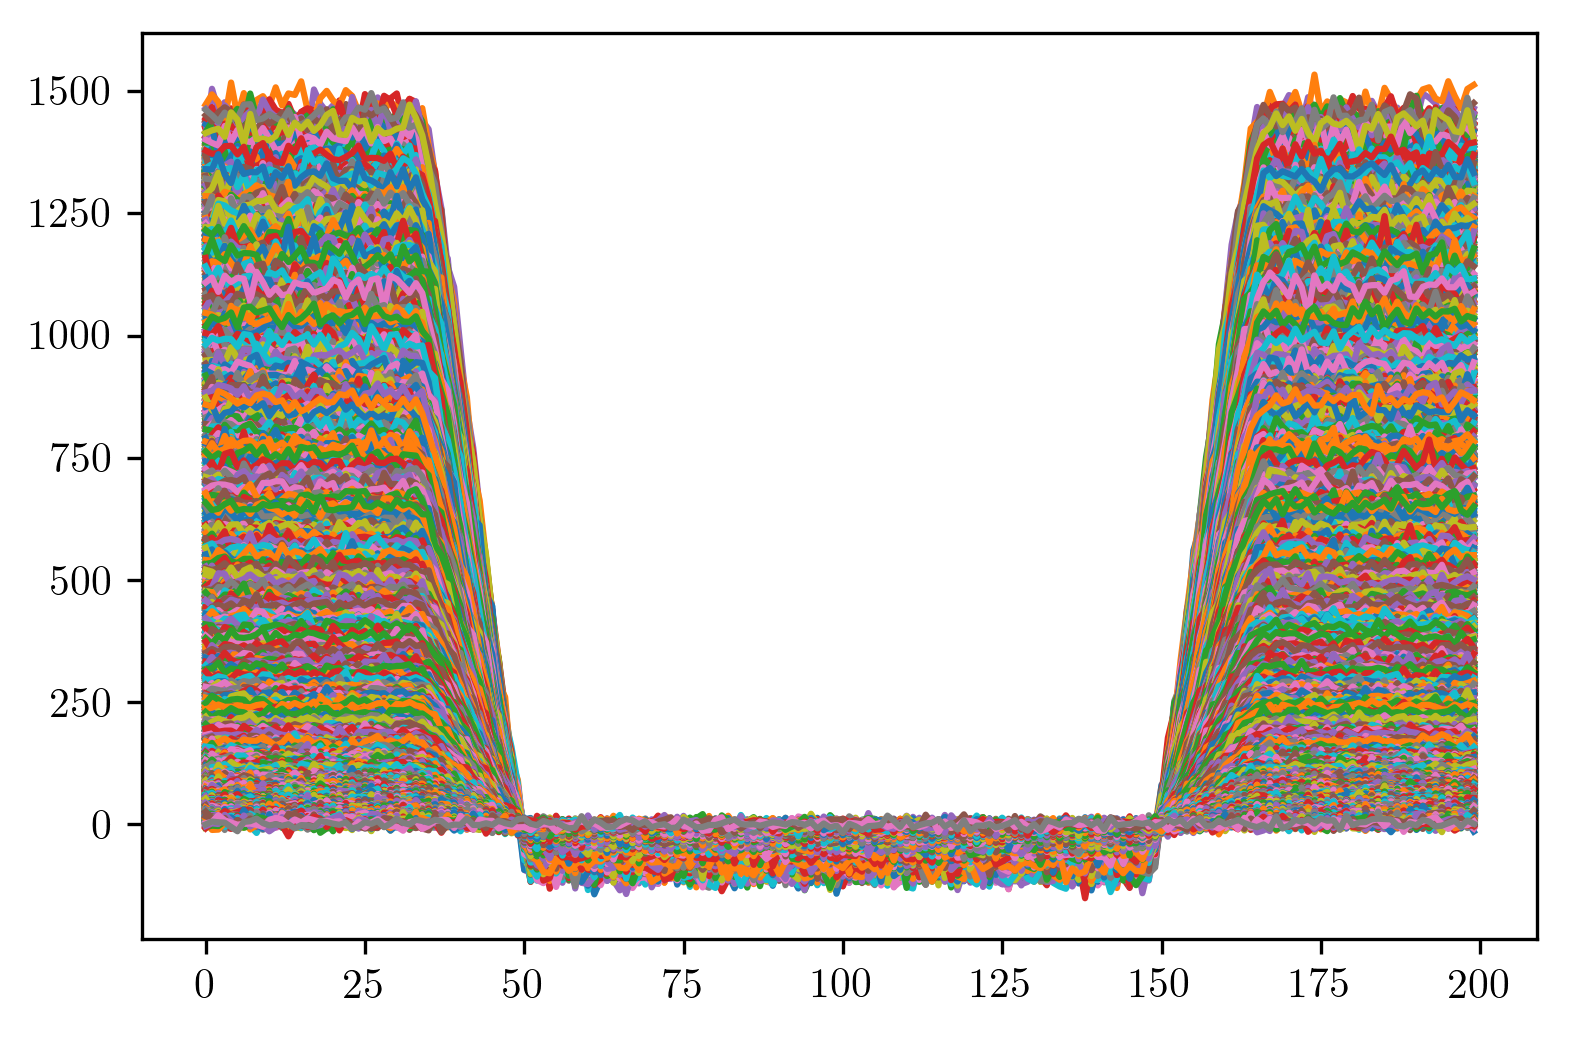

In [45]:
plt.plot(wasp107spec['counts'] - np.median(wasp107spec['counts'],axis=0));

**Assign Relevant Features and Guess at Error Bar**

In [46]:
spec1D_0= wasp107spec['counts']
wave    = wasp107spec['wavelength']
times   = np.linspace(-0.114,0.114, spec1D_0.shape[0])

err      = 3e-3                     # 3000 ppm uncertainty per point

**Establish Out of Transit Stellar Median**

In [47]:
nOOT    = 25
minAfter= 175
ootInds = np.array(list(np.arange(nOOT))+list(np.arange(nOOT)+minAfter))
medSpec = np.median(wasp107spec['counts'][ootInds],axis=0)

**Normalize Transit Light Curves to Median Stellar Spectrum**

In [48]:
spec1D = spec1D_0 / medSpec

**Get number of integrations and number of pixels**

In [49]:
nint, nx = spec1D.shape
print(nint, nx)

200 2048


**Grab Limb Darkening Coefficients -- Load From File**

In [50]:
binwave, u1, u2 = np.loadtxt('AWESim_SOSS/wasp107_data/WASP107_LDC.txt', skiprows=5, usecols=(0,1,3), unpack=True)

**Load limb-darkening coefficients**

In [51]:
wave_low = binwave - np.ediff1d(binwave)[0]/2.
wave_hi  = binwave + np.ediff1d(binwave)[0]/2.
nchan    = len(binwave)                             # Number of spectrophotometric channels
npix     = int(nx/nchan)                            # Number of pixels per channel
res      = np.mean(binwave)/np.ediff1d(binwave)[0]  # Mean resolution
print(nchan, npix, res)

85 24 82.475


**Plot 2D Transit Light Curves over TIME and WAVELENGTH**

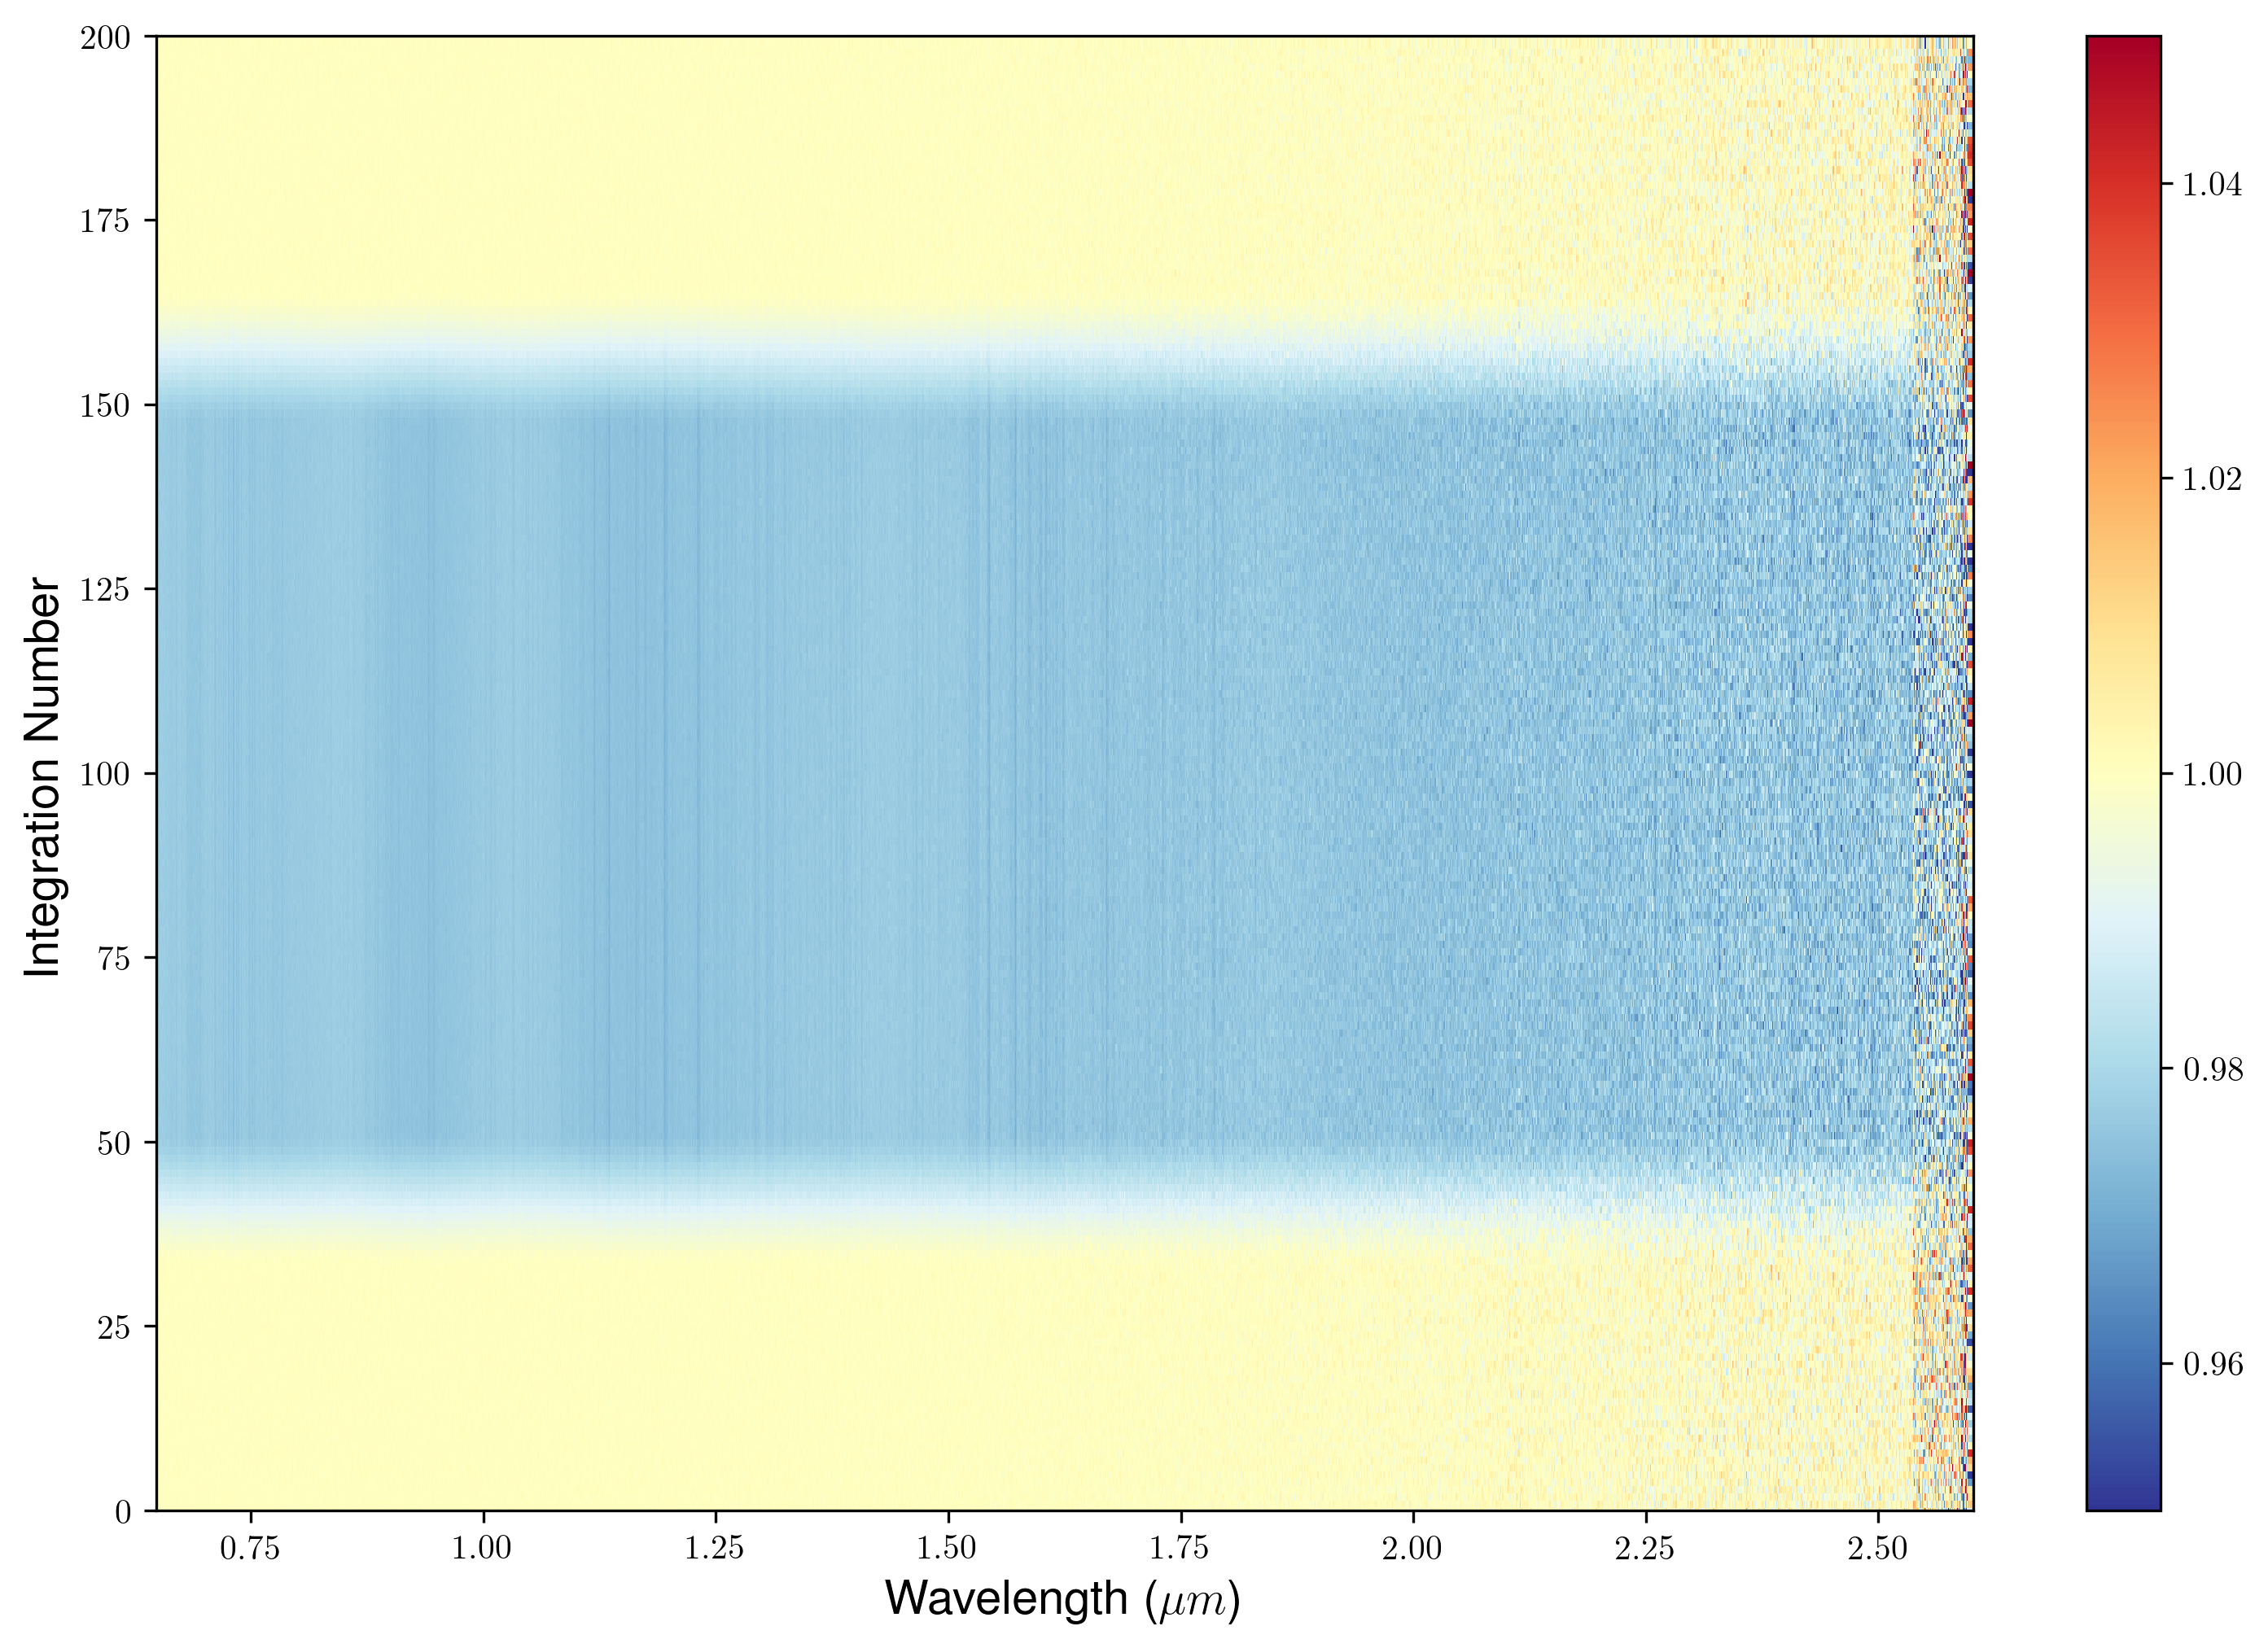

In [52]:
# Plot the time series of 1D spectra
# This may take a few seconds to complete
plt.figure(figsize=(12,8))
vmin        = 0.95#(spec1D/medSpec).min()
vmax        = 1.05#(spec1D/medSpec).max()

for j in range(nint):
    plt.scatter(wave, np.zeros(spec1D.shape[-1])+j, c=spec1D[j], 
                s=10,linewidths=0,vmin=vmin,vmax=vmax,marker='s',cmap=plt.cm.RdYlBu_r)

plt.xlim(wave[0],wave[-1])
plt.ylim(0,nint)
plt.ylabel('Integration Number', size=14)
plt.xlabel('Wavelength ($\mu m$)', size=14)
a=plt.colorbar()

**Bin Transit Features Down to nChan Channels**

In [53]:
# Bin 1D spectra into spectrophotometric channels
binflux = np.zeros((nchan,nint))
binerr  = np.zeros((nchan))
for i in range(nchan):
    index      = np.where((wave >= wave_low[i])*(wave <= wave_hi[i]))[0]
    binflux[i] = np.mean(spec1D[:,index],axis=1)
    binerr[i]  = np.sqrt(len(index))*err

**Fit BATMAN Models to each Binned transit Light Curve**

In [54]:
# Fit BATMAN transit model to each spectrophotometric light curve
results = []
for i in range(nchan):
    # Set initial parameters using an ordered dictionary of Parameter objects
    initialParams = lmfit.Parameters()
    # Format: (key, value, vary?, min, max)
    initialParams.add_many(                     # WASP-107b paramters from Anderson et al (2017)
        ('rprs' , 0.147, True, 0.0, 0.2),       # Free parameter
        ('period' , 5.721490, False),
        ('tcenter' , 0., False),
        ('inc' , 89.7, True),
        ('aprs' , 18.2, True),
        ('ecc' , 0., False),
        ('omega' , 90., False),
        ('u1' , u1[i], True),                  # Linear LD coefficient 
        ('u2' , u2[i], True),                  # Quadratic LD coefficient
        ('offset', 1.0, True, 0.0),             # Free parameter
        ('slope', 0.0, False),     
        ('curvature', 0.0, False))
    # Initialize model
    lcmodel = lmfit.Model(batman_wrapper_lmfit, independent_vars = ['times', 'ldtype', 'transitType'])
    # Fit light curve model to the simulated data
    results.append(lcmodel.fit(binflux[i],                   # data
                               weights     = 1/binerr[i],    # residuals = (data-model)*weights
                               params      = initialParams,  # Dependent parameters
                               times       = times,          # Independent paramter
                               ldtype      = 'quadratic',    # Independent paramter
                               transitType = 'primary',      # Independent paramter
                               method      = 'leastsq'))     # Fitting method

**Plot and Example Transit Light Curve with Corresponding Fit**

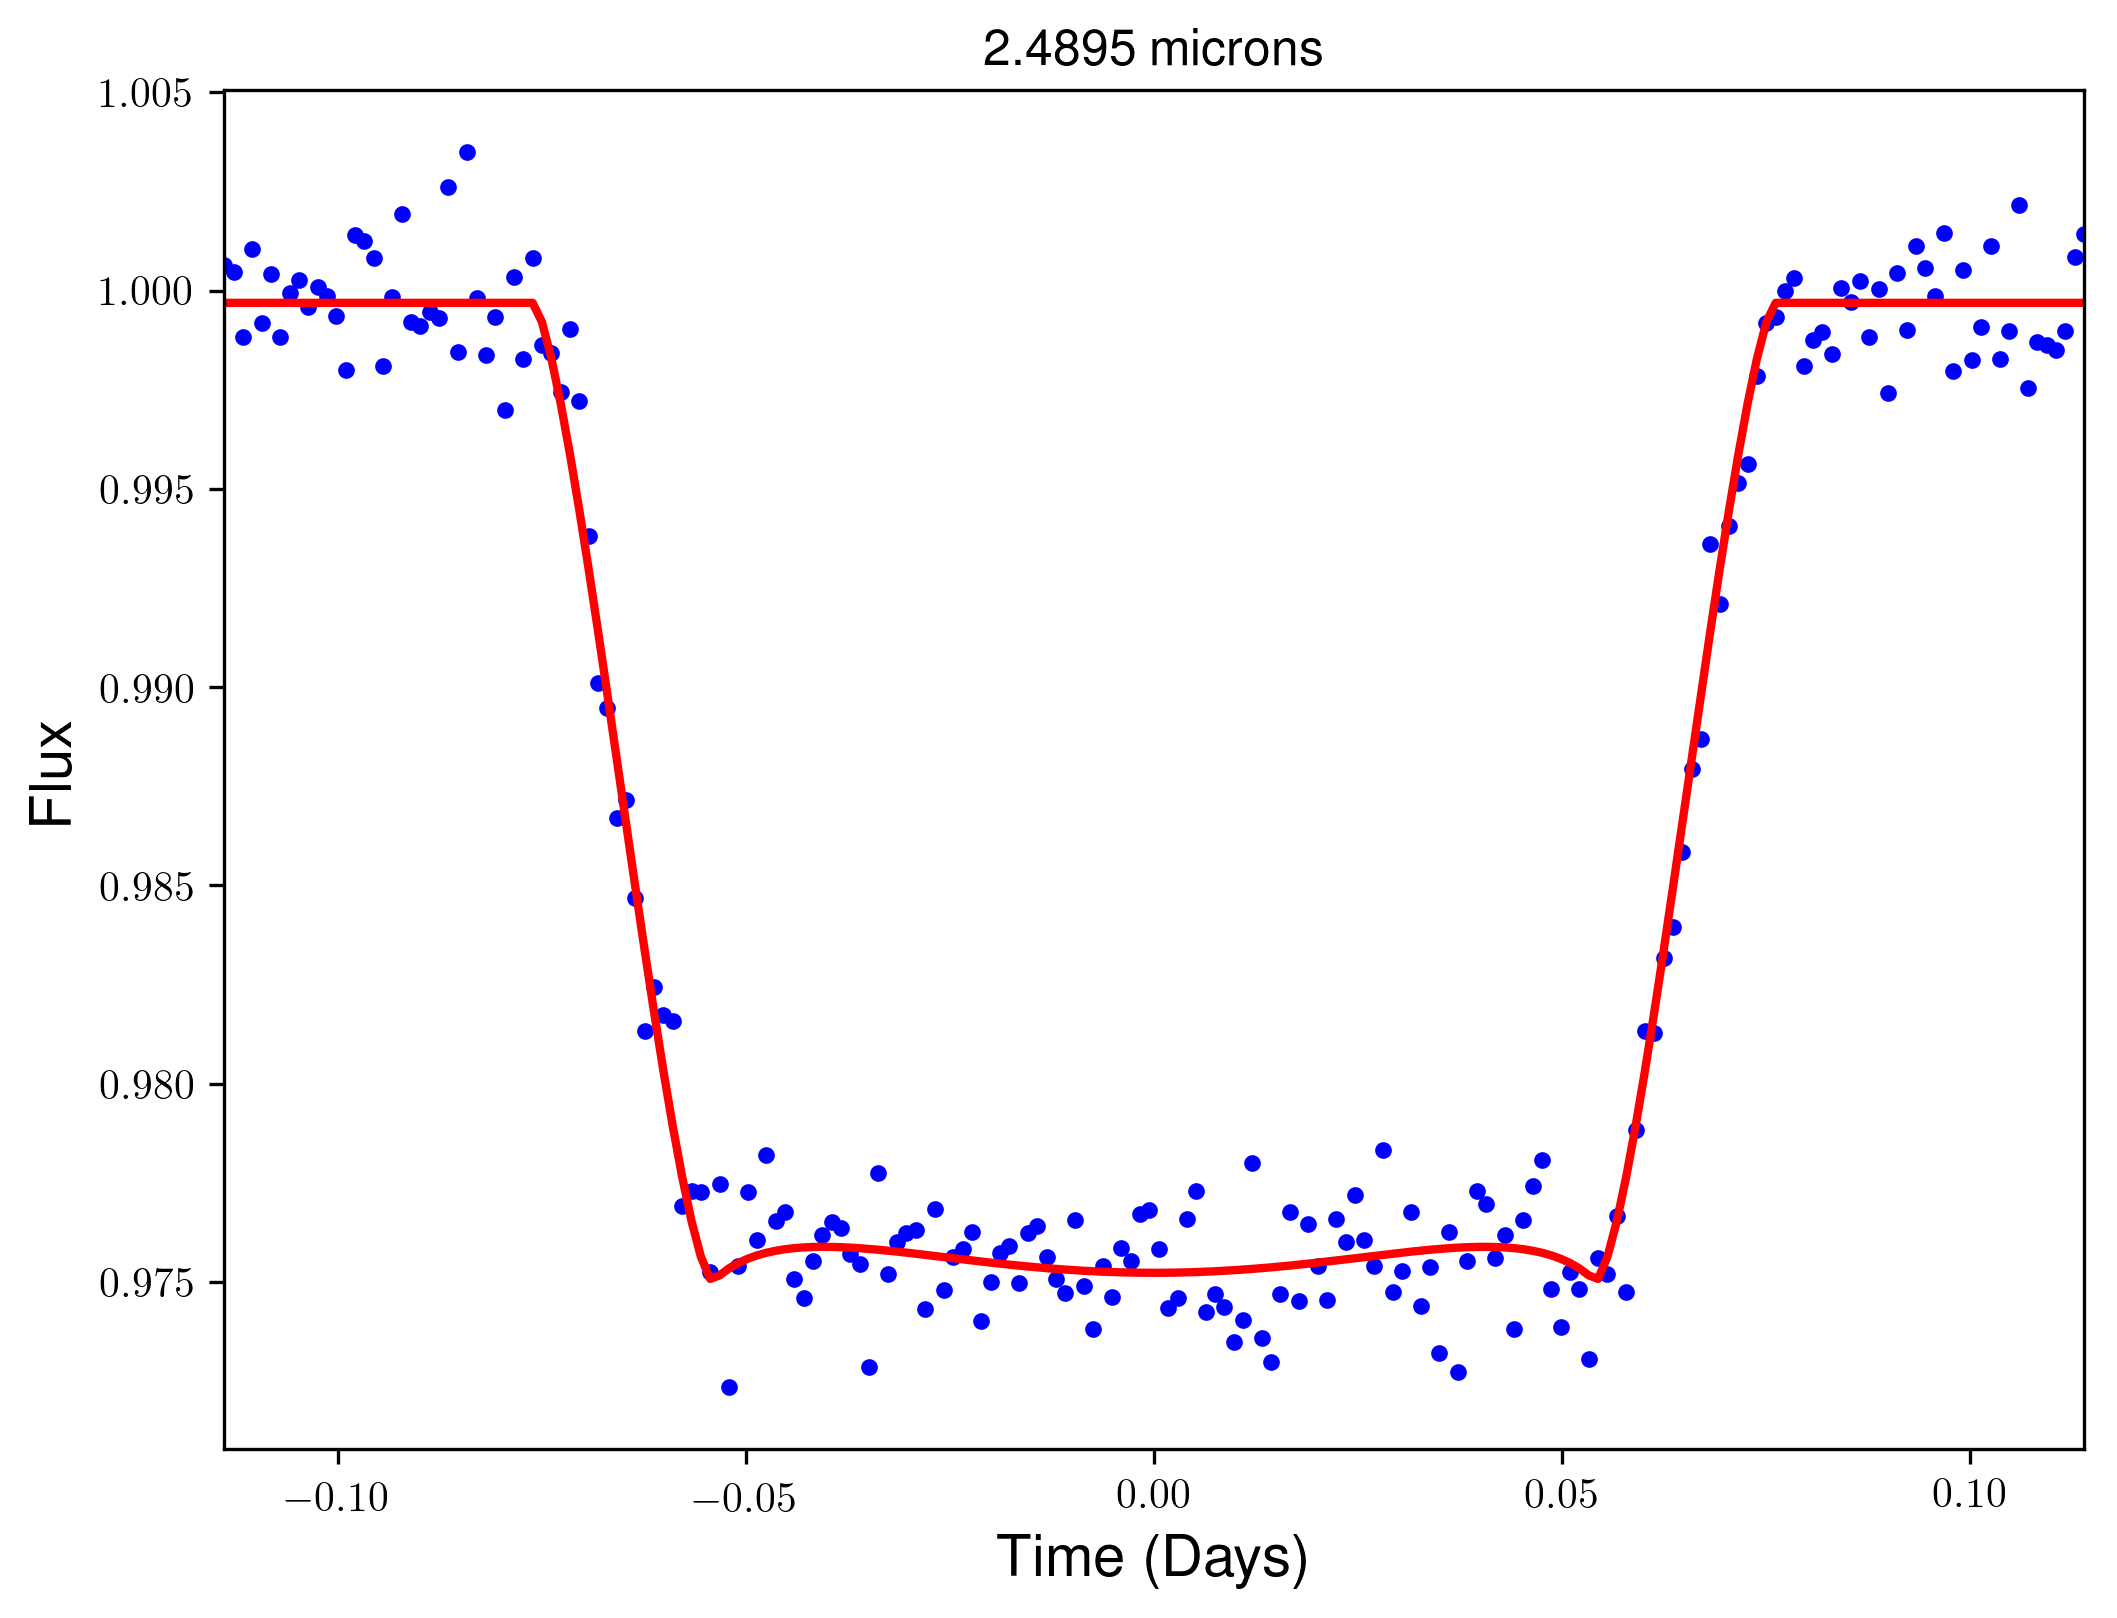

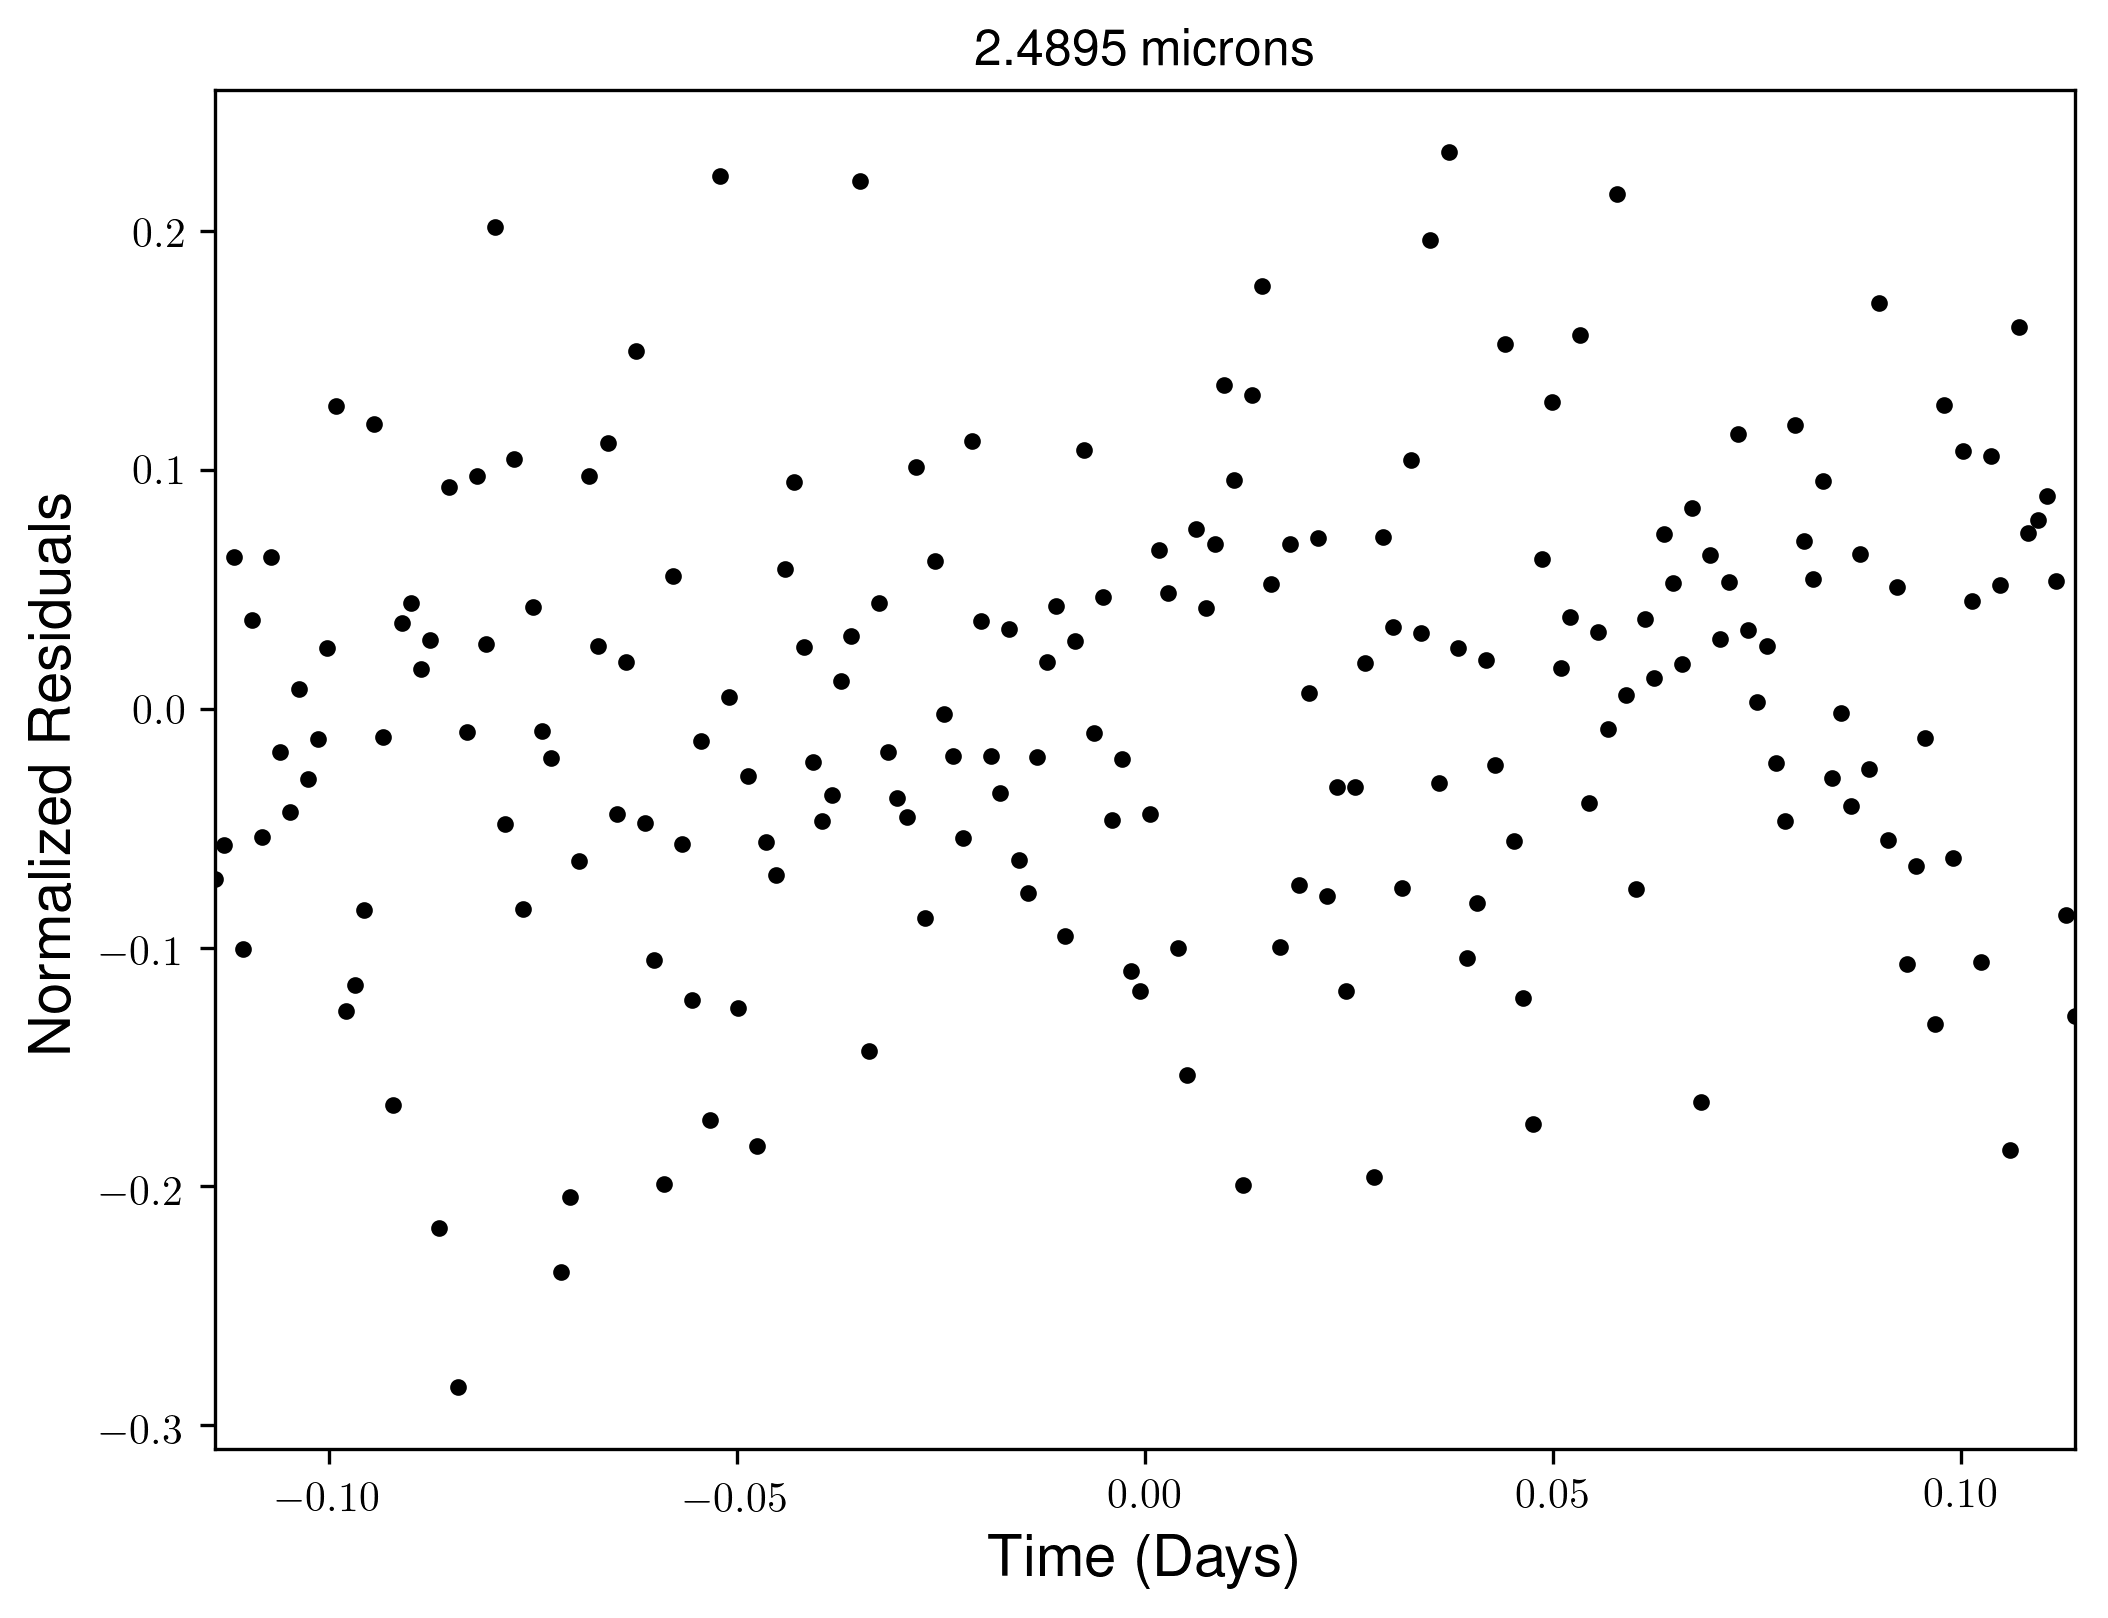

In [55]:
# Plot best fit light curve and residuals for the same channel
plt.figure(figsize=(8,6));
plt.title(str(binwave[i]) + " microns");
plt.plot(times, binflux[i], 'b.');
plt.plot(times, results[i].best_fit, 'r-', lw=2);
a=plt.xlim(times.min(), times.max());
plt.ylabel("Flux",size=14);
plt.xlabel("Time (Days)",size=14);
plt.figure(figsize=(8,6));
plt.title(str(binwave[i]) + " microns");
plt.plot(times, results[i].residual, 'k.');
a=plt.xlim(times.min(), times.max());
plt.ylabel("Normalized Residuals",size=14);
plt.xlabel("Time (Days)",size=14);

**Organize LMFIT Results into 'Observed' Transmission Spectrum**

In [56]:
# Record best-fit radii and formal errors
rprs    = np.zeros(nchan)
rprserr = np.zeros(nchan)
for i in range(nchan):
    rprs[i]    = results[i].best_values['rprs']
    try:
        rprserr[i] = np.sqrt(results[i].covar[0,0])       # Assumes RpRs is 0th free parameter
    except:
        rprserr[i] = np.nan       # Assumes RpRs is 0th free parameter

**Load Injected WASP107b Transmission Spectrum for Comparison**

In [57]:
WASP107b = np.genfromtxt('AWESim_SOSS/wasp107_data/WASP107b_pandexo_input_spectrum.dat', unpack=True)

**Plot 'Observed' Transmission Spectrum**

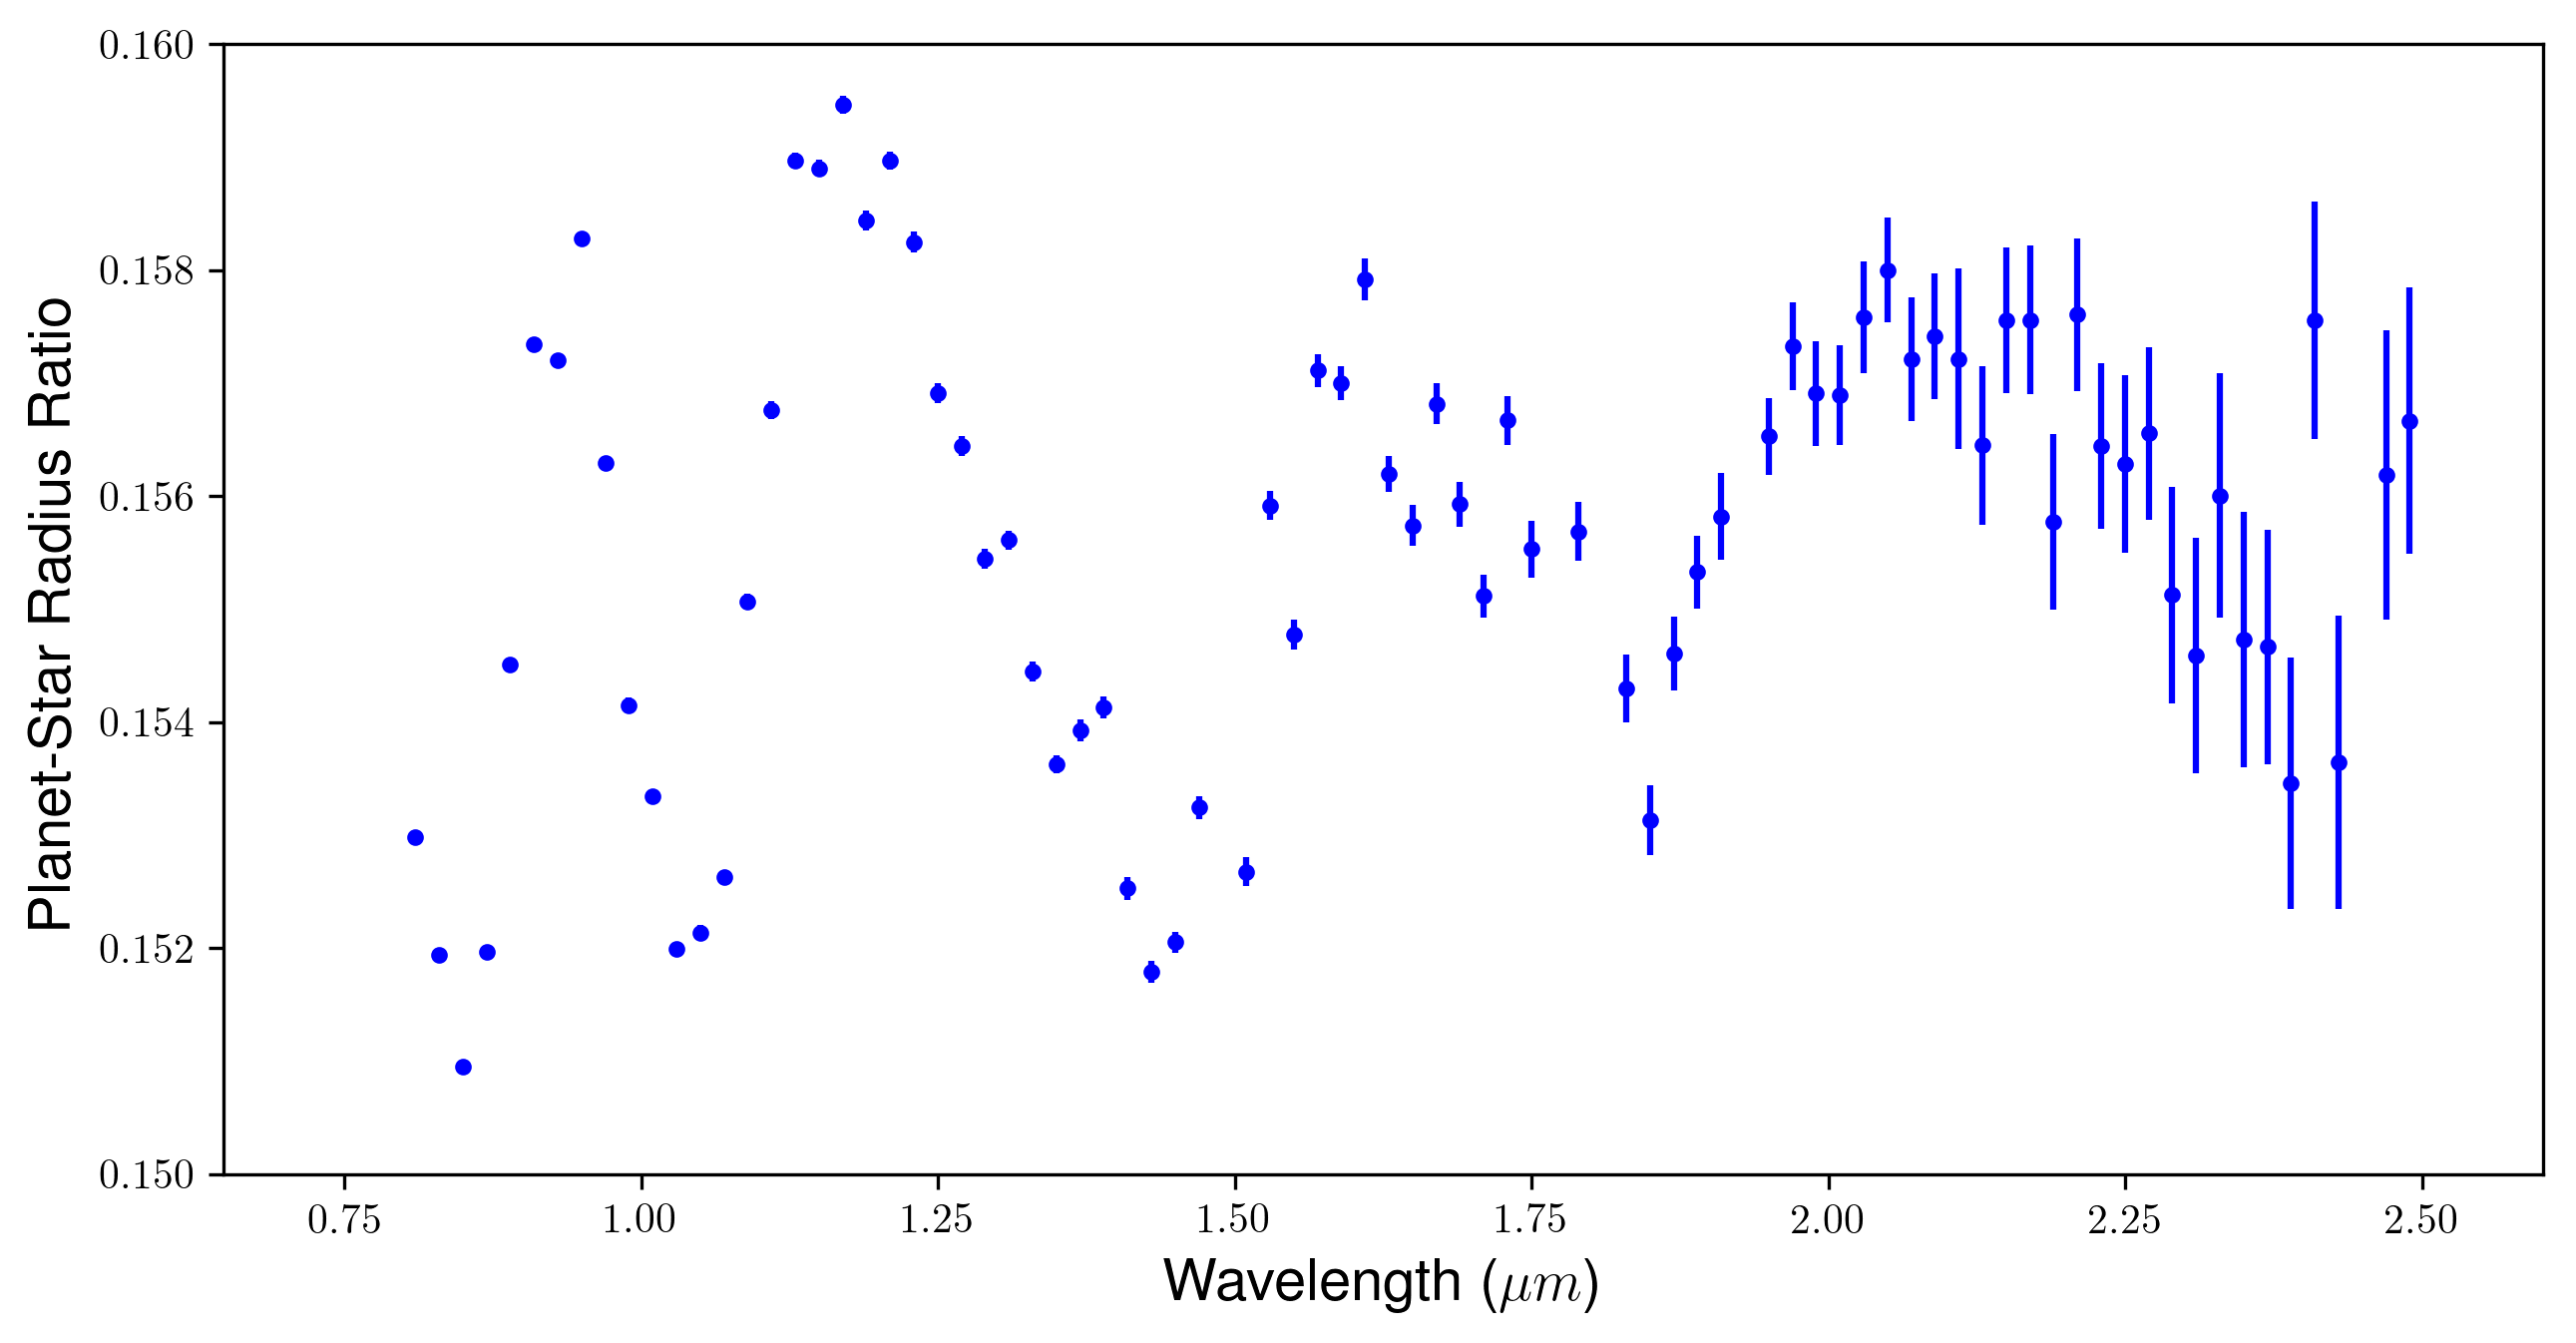

In [58]:
# Plot transmission spectrum
plt.figure(figsize=(10,5))
plt.errorbar(binwave, rprs, rprserr, fmt='b.')
plt.ylabel("Planet-Star Radius Ratio",size=14)
plt.xlabel("Wavelength ($\mu m$)",size=14)
a=plt.xlim(wave[0],wave[-1])
plt.ylim(0.150, 0.160);

**Compare 'Observed' to Injected Planetary Spectrum**

For today, we have to rescale the injected spectrum to the observed spectrum.

The primary concern is not the scale, but the lack of common-mode variations (the bumps are misaligned)

In [59]:
from scipy.signal import medfilt

In [60]:
waveUse     = (WASP107b[0]>binwave.min())*(WASP107b[0]<binwave.max())
wasp107b_wv = WASP107b[0][waveUse]
wasp107b_cr = WASP107b[1][waveUse]
wasp107b_sm = medfilt(wasp107b_cr,101)
wasp107b_rng= (0.159-0.151)
wasp107b_wid= (0.159+0.151)
observed_rng=(wasp107b_sm.max() - np.min(wasp107b_sm))
wasp107b_rs = (wasp107b_sm - np.min(wasp107b_sm)) / observed_rng * wasp107b_rng + 0.5 * wasp107b_wid

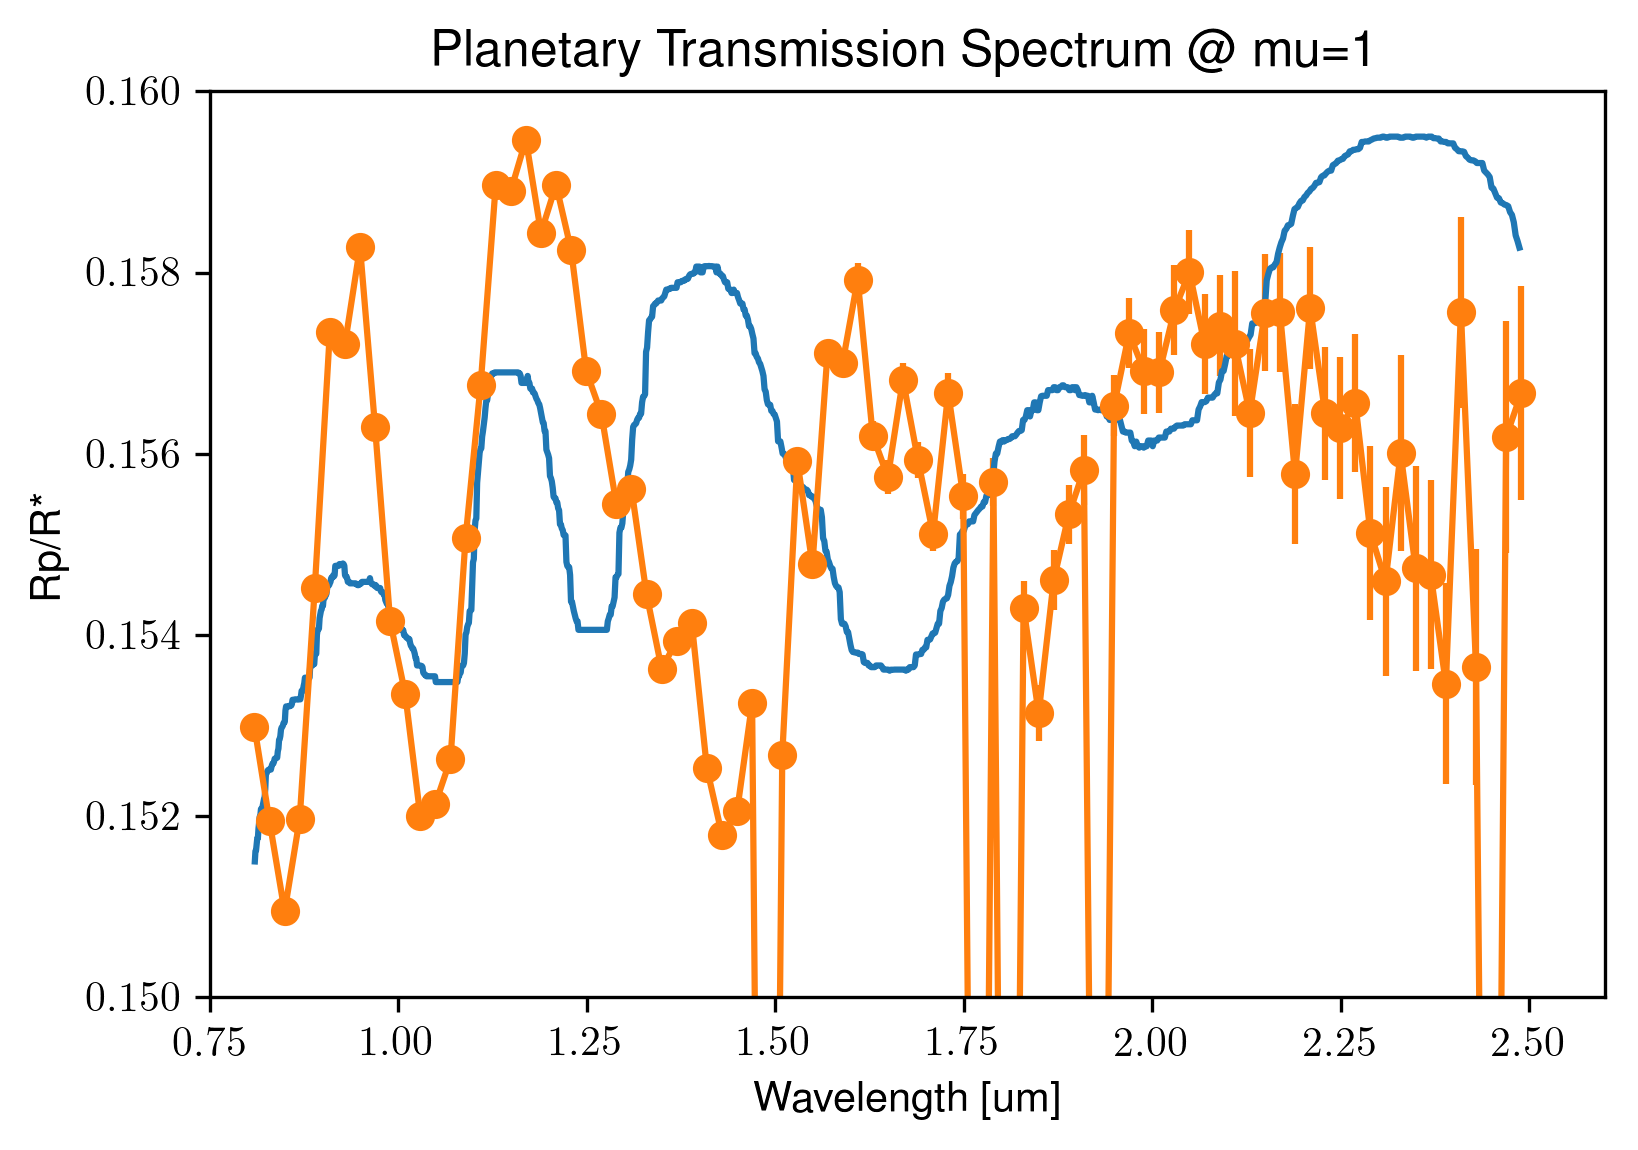

In [61]:
plt.plot(wasp107b_wv, wasp107b_rs-3.5e-3)
plt.errorbar(binwave, rprs, rprserr, fmt='o-')
plt.ylim(0.150, 0.160)
plt.xlim(0.75,2.6)
plt.title('Planetary Transmission Spectrum @ mu=1')
plt.ylabel('Rp/R*')
plt.xlabel('Wavelength [um]')

**Save results to file**

In [62]:
joblib.dump(dict(binwave=binwave, rprs=rprs, rprserr=rprserr), "AWESim_SOSS/example_results/WASP107b-TranSpec.save");